Downloading libraries

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Reading out the csv file

In [2]:
energy = pd.read_csv('energy.csv')
energy.head(5)

#Day represents the dat data was recorded
#LCLid is the ID for the home the data was recorded from
#Energy_sum is the sum of energu used by the house in the given day

,Unnamed: 0,day,LCLid,energy_sum
0,0,2012-10-12,MAC000002,7.098
1,1,2012-10-13,MAC000002,11.087
2,2,2012-10-14,MAC000002,13.223
3,3,2012-10-15,MAC000002,10.257
4,4,2012-10-16,MAC000002,9.769


Count number of households participating in data as time goes by

In [3]:
#Increasing use of smart meters in london 
#Number of households which energy data was collected across different days are different
#possible interpretation that energy use is high on a given day when more data from houses is collected on a certain day
#This can be mitigated by using energy used per household
Count_houses = energy.groupby('day')[['LCLid']].nunique()
Count_houses #Some days have significantly more counts/data points that others


,LCLid
day,
2011-11-23,11
2011-11-24,20
2011-11-25,25
2011-11-26,33
2011-11-27,33
...,...
2014-02-24,2700
2014-02-25,2701
2014-02-26,2700


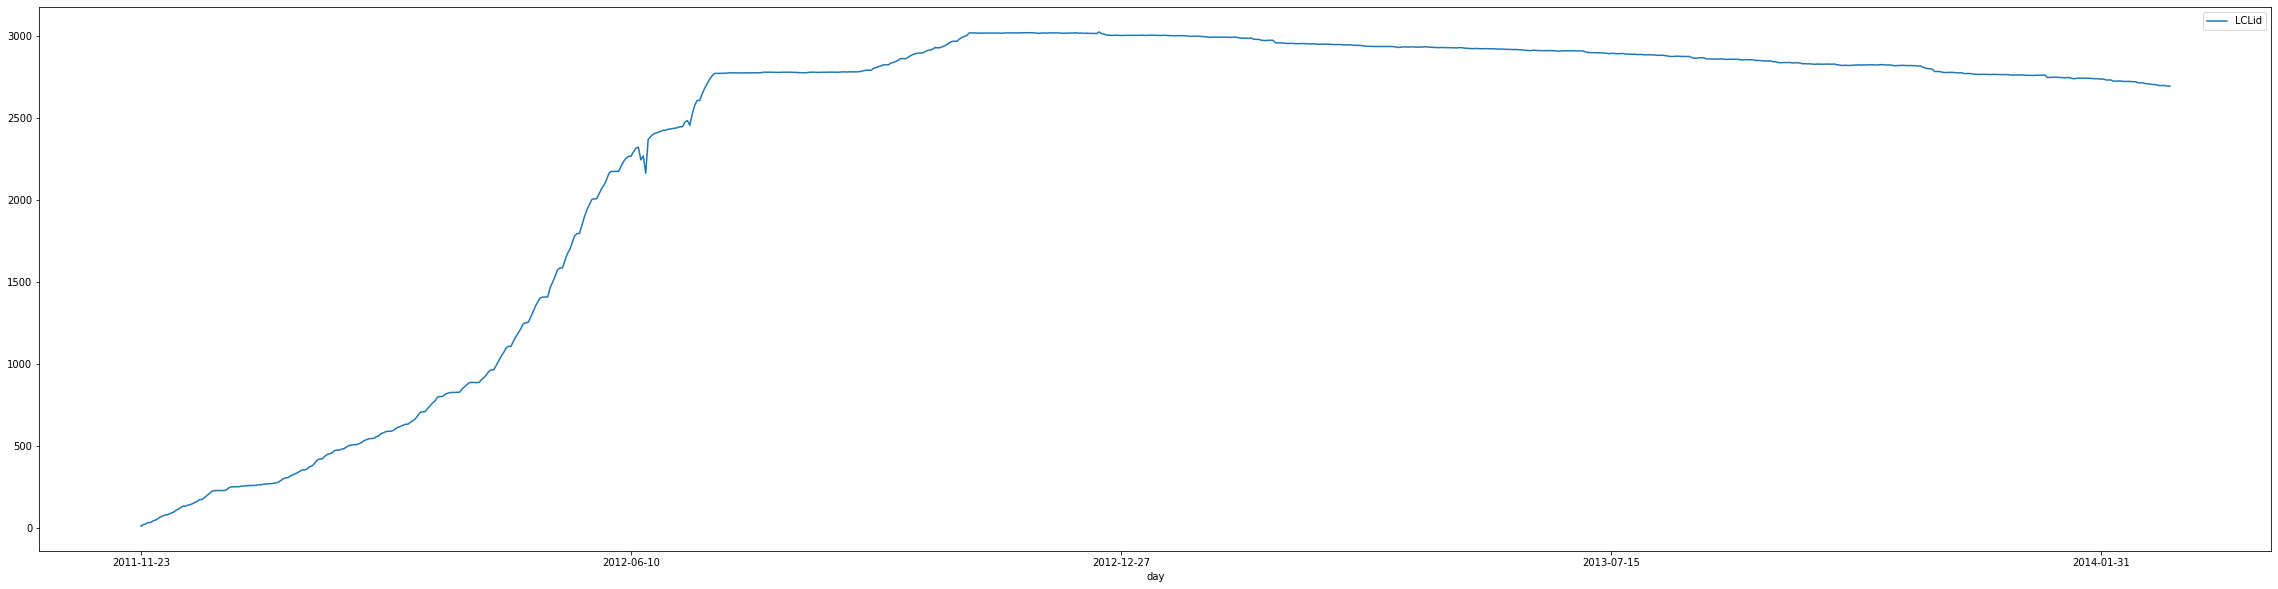

In [4]:
Count_houses.plot(figsize=(40,10))
#as shown in graph below, significant increase in people using smart meters
#More data is collected from different house holds as they grow in popularity 
#This means historical data is limited as smart meters are relatively recent


In [5]:
#Due to the data inconsistencies energy per household will be used as a prediction metric
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(Count_houses, on = ['day'])
energy = energy.reset_index()
energy.count()
#Data for houses is now normalized

day           829
energy_sum    829
LCLid         829
dtype: int64

In [6]:
energy

,day,energy_sum,LCLid
0,2011-11-23,78.968000,11
1,2011-11-24,177.228000,20
2,2011-11-25,246.590000,25
3,2011-11-26,357.634000,33
4,2011-11-27,361.435001,33
...,...,...,...
824,2014-02-24,31550.097002,2700
825,2014-02-25,31359.870999,2701
826,2014-02-26,31030.465999,2700
827,2014-02-27,31556.972999,2697


In [7]:
energy.day = pd.to_datetime(energy.day, format ='%Y-%m-%d').dt.date #Put time stamp on energy data
energy['avg_energy'] = energy['energy_sum']/energy['LCLid'] 
#Creating new varibale of average energy from sum of energy and how many times data is recorded for each house ID
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,26326.703382,2354.799759,11.321449
std,12136.921124,951.698443,2.125048
min,78.968000,11.000000,0.233353
25%,21583.501999,2372.000000,9.302350
50%,27567.735999,2823.000000,11.241011
75%,35887.285003,2932.000000,13.008831
max,51371.893998,3028.000000,17.095472


Read csv for weather data

In [8]:
#Displaying weather information
weather = pd.read_csv('weather_daily_darksky.csv')
weather.head(5)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,rain,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 00:00:00,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,rain,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 00:00:00,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,5.02,rain,13.16,0.80,2011-12-24 15:00:00,4.37,5.32,1.0,2011-12-24 00:00:00,2011-12-24 15:55:55,7.45,3.17,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [9]:
weather.describe()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


In [10]:
weather['day']=  pd.to_datetime(weather['time']) # give weather data time stamp of day
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date #time stamp date order

weather = weather.dropna() #drop any missing values

In [11]:
#merge energy usage and weather with time stamp
weather_energy =  energy.merge(weather, on=['day'])
weather_energy.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,2011-11-23,78.968000,11,7.178909,10.36,2011-11-23 14:00:00,229,fog,6.29,2011-11-23 07:00:00,0.36,2.04,1027.12,2011-11-23 07:00:00,10.36,rain,8.06,0.93,2011-11-23 14:00:00,6.56,10.36,1.0,2011-11-23 00:00:00,2011-11-23 16:03:50,8.24,3.81,10.36,2011-11-23 07:32:38,2011-11-23 14:00:00,2011-11-23 10:00:00,Foggy in the morning.,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94
1,2011-11-24,177.228000,20,8.861400,12.93,2011-11-24 12:00:00,204,partly-cloudy-night,8.56,2011-11-24 02:00:00,0.41,4.04,1027.22,2011-11-24 02:00:00,12.93,rain,10.64,0.89,2011-11-24 12:00:00,7.30,12.93,1.0,2011-11-24 00:00:00,2011-11-24 16:02:48,9.71,8.56,12.93,2011-11-24 07:34:14,2011-11-24 12:00:00,2011-11-24 10:00:00,Partly cloudy throughout the day.,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97
2,2011-11-25,246.590000,25,9.863600,13.03,2011-11-25 05:00:00,243,partly-cloudy-day,7.24,2011-11-25 23:00:00,0.48,5.02,1024.47,2011-11-25 23:00:00,12.27,rain,12.38,0.79,2011-11-25 12:00:00,4.69,13.03,1.0,2011-11-25 00:00:00,2011-11-25 16:01:49,7.01,7.46,12.27,2011-11-25 07:35:49,2011-11-25 12:00:00,2011-11-25 10:00:00,Partly cloudy throughout the day.,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01
3,2011-11-26,357.634000,33,10.837394,12.96,2011-11-26 14:00:00,237,wind,6.96,2011-11-26 01:00:00,0.44,5.75,1025.80,2011-11-26 05:00:00,12.96,rain,13.07,0.81,2011-11-26 14:00:00,11.59,12.96,1.0,2011-11-26 00:00:00,2011-11-26 16:00:53,11.59,7.01,12.96,2011-11-26 07:37:22,2011-11-26 14:00:00,2011-11-26 10:00:00,Mostly cloudy throughout the day and breezy ov...,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05
4,2011-11-27,361.435001,33,10.952576,13.54,2011-11-27 10:00:00,256,wind,5.76,2011-11-27 23:00:00,0.42,5.48,1021.11,2011-11-27 23:00:00,13.54,rain,13.08,0.72,2011-11-27 10:00:00,1.31,13.54,1.0,2011-11-27 00:00:00,2011-11-27 16:00:00,1.31,4.47,13.54,2011-11-27 07:38:54,2011-11-27 10:00:00,2011-11-27 10:00:00,Breezy in the morning and partly cloudy until ...,2011-11-28 05:00:00,2.94,2011-11-27 10:00:00,2011-11-28 05:00:00,0.08


Plotting weather data with energy use

No handles with labels found to put in legend.
No handles with labels found to put in legend.


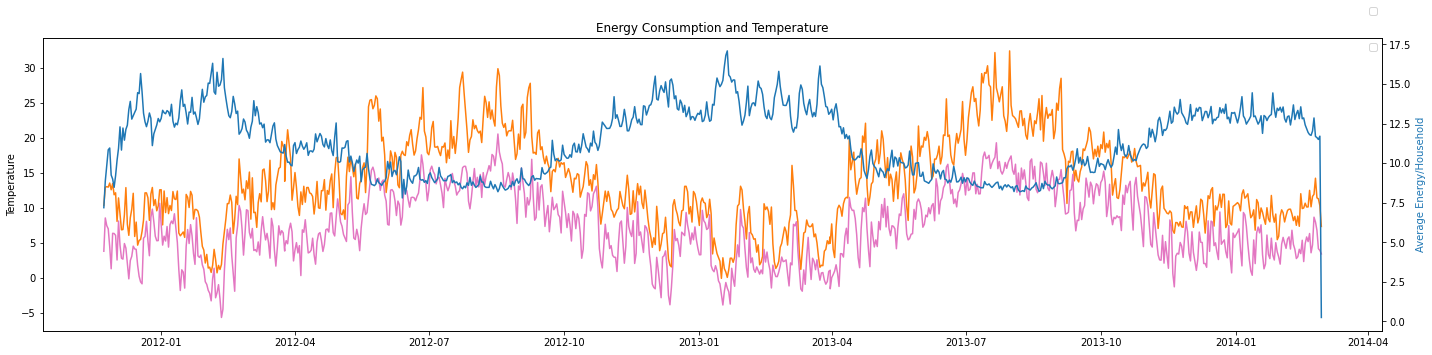

In [12]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
#Maximum tempreture recorded on that given day is displayed in orange
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
#Minimum tempreture recorded in that given day recorded in pink
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
#Average energy used by the household in blue
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

#CLear trent shown as reduction in temoreture typically causes an increase in energy consumption

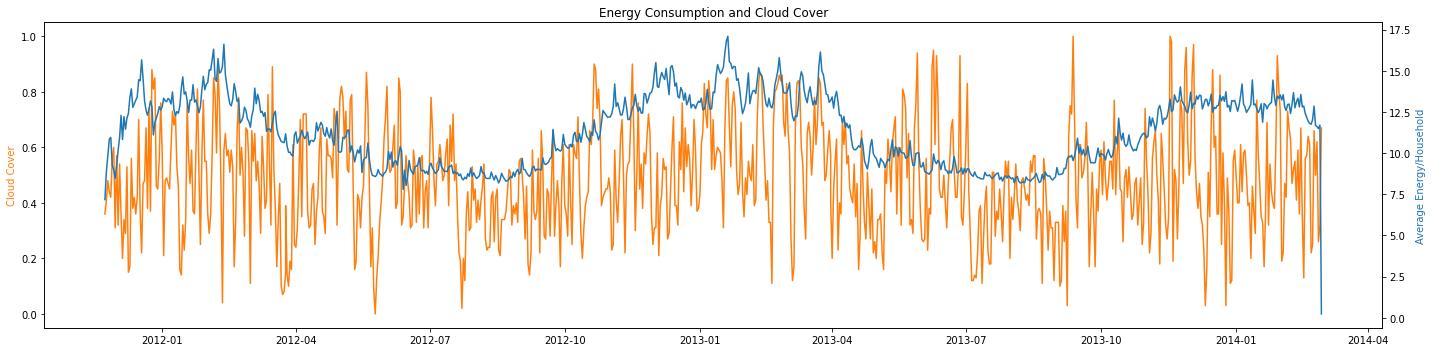

In [13]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
#Cloud cover variable shown in red
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()
#Correlation between cloud cover and energy consumption is evident

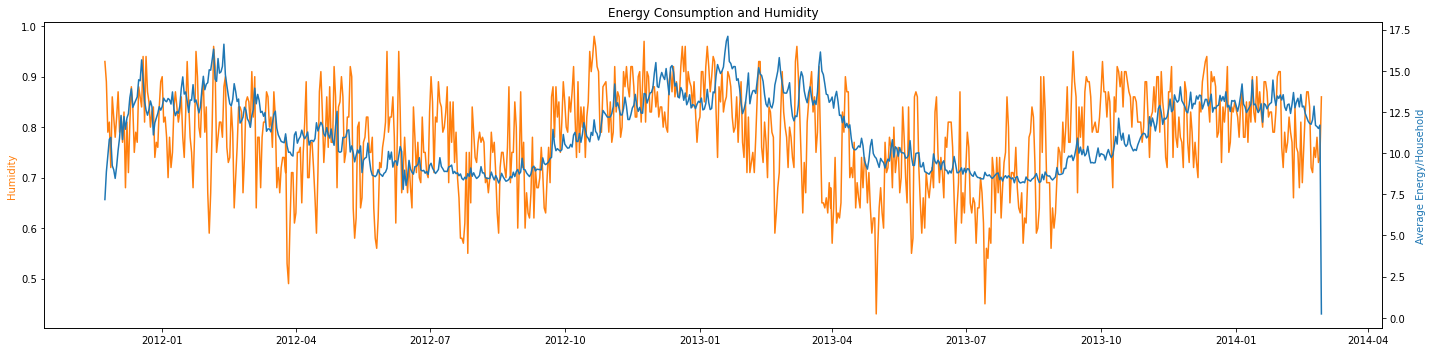

In [14]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
#Humidity shown as orange
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()
#strong correlation shown between humidity levels and energy consumption
#Expected as increase use of heat during humid conditions

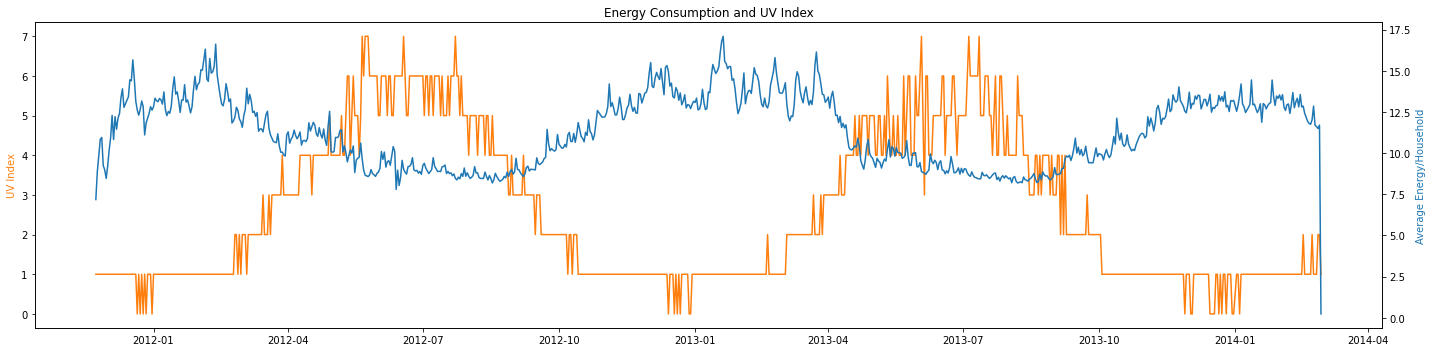

In [15]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()
#Extremely high UV index indicates it is very sunny 
#In extremely sunny and hot days there is a natural increase in energy usage
#However in general when the UV index is high energy consumption is less

In [16]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix
#Correlation matrix between the features to identify which correlations are strongest

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.864638,-0.765937,0.258700,0.154205,-0.084048,-0.263624,0.378306,-0.739018,-0.028249
temperatureMax,-0.864638,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.765937,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.258700,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.154205,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.084048,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.263624,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.378306,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.739018,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.028249,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


Read weekends and bank holiday csv /
Merge weather and calender dataset

In [17]:
holiday = pd.read_excel('Bank_holidays_new.xlsx')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%m/%d/%Y').dt.date
holiday.head(5)
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

holiday.head(10)

,Bank holidays
0,2011-11-23
1,2011-11-26
2,2011-11-27
3,2011-12-03
4,2011-12-04
5,2011-12-10
6,2011-12-11
7,2011-12-17
8,2011-12-18
9,2011-12-24


In [18]:
weather_energy

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind
0,2011-11-23,78.968000,11,7.178909,10.36,2011-11-23 14:00:00,229,fog,6.29,2011-11-23 07:00:00,0.36,2.04,1027.12,2011-11-23 07:00:00,10.36,rain,8.06,0.93,2011-11-23 14:00:00,6.56,10.36,1.0,2011-11-23 00:00:00,2011-11-23 16:03:50,8.24,3.81,10.36,2011-11-23 07:32:38,2011-11-23 14:00:00,2011-11-23 10:00:00,Foggy in the morning.,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94,2011-11-23,1
1,2011-11-24,177.228000,20,8.861400,12.93,2011-11-24 12:00:00,204,partly-cloudy-night,8.56,2011-11-24 02:00:00,0.41,4.04,1027.22,2011-11-24 02:00:00,12.93,rain,10.64,0.89,2011-11-24 12:00:00,7.30,12.93,1.0,2011-11-24 00:00:00,2011-11-24 16:02:48,9.71,8.56,12.93,2011-11-24 07:34:14,2011-11-24 12:00:00,2011-11-24 10:00:00,Partly cloudy throughout the day.,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97,NaN,0
2,2011-11-25,246.590000,25,9.863600,13.03,2011-11-25 05:00:00,243,partly-cloudy-day,7.24,2011-11-25 23:00:00,0.48,5.02,1024.47,2011-11-25 23:00:00,12.27,rain,12.38,0.79,2011-11-25 12:00:00,4.69,13.03,1.0,2011-11-25 00:00:00,2011-11-25 16:01:49,7.01,7.46,12.27,2011-11-25 07:35:49,2011-11-25 12:00:00,2011-11-25 10:00:00,Partly cloudy throughout the day.,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01,NaN,0
3,2011-11-26,357.634000,33,10.837394,12.96,2011-11-26 14:00:00,237,wind,6.96,2011-11-26 01:00:00,0.44,5.75,1025.80,2011-11-26 05:00:00,12.96,rain,13.07,0.81,2011-11-26 14:00:00,11.59,12.96,1.0,2011-11-26 00:00:00,2011-11-26 16:00:53,11.59,7.01,12.96,2011-11-26 07:37:22,2011-11-26 14:00:00,2011-11-26 10:00:00,Mostly cloudy throughout the day and breezy ov...,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05,2011-11-26,1
4,2011-11-27,361.435001,33,10.952576,13.54,2011-11-27 10:00:00,256,wind,5.76,2011-11-27 23:00:00,0.42,5.48,1021.11,2011-11-27 23:00:00,13.54,rain,13.08,0.72,2011-11-27 10:00:00,1.31,13.54,1.0,2011-11-27 00:00:00,2011-11-27 16:00:00,1.31,4.47,13.54,2011-11-27 07:38:54,2011-11-27 10:00:00,2011-11-27 10:00:00,Breezy in the morning and partly cloudy until ...,2011-11-28 05:00:00,2.94,2011-11-27 10:00:00,2011-11-28 05:00:00,0.08,2011-11-27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,2014-02-24,31550.097002,2700,11.685221,14.23,2014-02-24 13:00:00,183,wind,6.03,2014-02-24 07:00:00,0.50,5.02,1005.19,2014-02-24 08:00:00,14.23,rain,13.00,0.74,2014-02-24 13:00:00,4.78,14.23,1.0,2014-02-24 00:00:00,2014-02-24 17:32:15,8.25,7.99,14.23,2014-02-24 06:58:05,2014-02-24 13:00:00,2014-02-24 09:00:00,Mostly cloudy until evening and breezy overnight.,2014-02-25 03:00:00,5.52,2014-02-24 13:00:00,2014-02-25 03:00:00,0.82,NaN,0
825,2014-02-25,31359.870999,2701,11.610467,11.43,2014-02-25 00:00:00,202,partly-cloudy-day,5.06,2014-02-25 21:00:00,0.62,5.69,1000.65,2014-02-25 11:00:00,10.31,rain,12.09,0.78,2014-02-25 14:00:00,1.67,11.43,1.0,2014-02-25 00:00:00,2014-02-25 17:34:02,4.17,6.79,10.31,2014-02-25 06:55:59,2014-02-25 14:00:00,2014-02-25 09:00:00,Mostly cloudy throughout the day.,2014-02-26 07:00:00,3.89,2014-02-25 00:00:00,2014-02-26 07:00:00,0.86,NaN,0
826,2014-02-26,31030.465999,2700,11.492765,11.29,2014-02-26 13:00:00,227,partly-cloudy-day,2.74,2014-02-26 07:00:00,0.26,3.82,1012.73,2014-02-26 07:00:00,11.29,rain,13.00,0.73,2014-02-26 13:00:00,3.03,11.29,2.0,2014-02-26 00:00:00,2014-02-26 17:35:49,6.01,4.17

In [19]:
#avg_energy in last row (828) contains glaring outlier
#remove instead of replacing with average of the row
#enough data available to make removal inconsequential 
weather_energy = weather_energy.drop(828)
weather_energy.tail()

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind
823,2014-02-23,34728.798992,2702,12.852997,11.94,2014-02-23 16:00:00,200,wind,6.17,2014-02-23 02:00:00,0.66,7.10,1010.37,2014-02-23 02:00:00,11.94,rain,12.33,0.76,2014-02-23 16:00:00,5.52,11.94,1.0,2014-02-23 00:00:00,2014-02-23 17:30:27,7.99,8.67,11.94,2014-02-23 07:00:09,2014-02-23 16:00:00,2014-02-23 10:00:00,Mostly cloudy until evening and breezy until a...,2014-02-24 07:00:00,5.53,2014-02-23 16:00:00,2014-02-24 08:00:00,0.78,2014-02-23,1
824,2014-02-24,31550.097002,2700,11.685221,14.23,2014-02-24 13:00:00,183,wind,6.03,2014-02-24 07:00:00,0.50,5.02,1005.19,2014-02-24 08:00:00,14.23,rain,13.00,0.74,2014-02-24 13:00:00,4.78,14.23,1.0,2014-02-24 00:00:00,2014-02-24 17:32:15,8.25,7.99,14.23,2014-02-24 06:58:05,2014-02-24 13:00:00,2014-02-24 09:00:00,Mostly cloudy until evening and breezy overnight.,2014-02-25 03:00:00,5.52,2014-02-24 13:00:00,2014-02-25 03:00:00,0.82,NaN,0
825,2014-02-25,31359.870999,2701,11.610467,11.43,2014-02-25 00:00:00,202,partly-cloudy-day,5.06,2014-02-25 21:00:00,0.62,5.69,1000.65,2014-02-25 11:00:00,10.31,rain,12.09,0.78,2014-02-25 14:00:00,1.67,11.43,1.0,2014-02-25 00:00:00,2014-02-25 17:34:02,4.17,6.79,10.31,2014-02-25 06:55:59,2014-02-25 14:00:00,2014-02-25 09:00:00,Mostly cloudy throughout the day.,2014-02-26 07:00:00,3.89,2014-02-25 00:00:00,2014-02-26 07:00:00,0.86,NaN,0
826,2014-02-26,31030.465999,2700,11.492765,11.29,2014-02-26 13:00:00,227,partly-cloudy-day,2.74,2014-02-26 07:00:00,0.26,3.82,1012.73,2014-02-26 07:00:00,11.29,rain,13.00,0.73,2014-02-26 13:00:00,3.03,11.29,2.0,2014-02-26 00:00:00,2014-02-26 17:35:49,6.01,4.17,11.29,2014-02-26 06:53:52,2014-02-26 13:00:00,2014-02-26 12:00:00,Partly cloudy throughout the day.,2014-02-27 00:00:00,1.67,2014-02-26 13:00:00,2014-02-27 00:00:00,0.90,NaN,0
827,2014-02-27,31556.972999,2697,11.700769,10.31,2014-02-27 14:00:00,224,partly-cloudy-day,3.08,2014-02-27 23:00:00,0.32,4.14,1007.02,2014-02-27 22:00:00,10.31,rain,12.04,0.74,2014-02-27 14:00:00,0.82,10.31,2.0,2014-02-27 00:00:00,2014-02-27 17:37:35,3.43,3.93,10.31,2014-02-27 06:51:45,2014-02-27 14:00:00,2014-02-27 12:00:00,Partly cloudy until evening.,2014-02-28 02:00:00,1.41,2014-02-27 14:00:00,2014-02-28 02:00:00,0.93,NaN,0


In [20]:
weather_energy.dtypes
#As shown all the data 

day                             object
energy_sum                     float64
LCLid                            int64
avg_energy                     float64
temperatureMax                 float64
temperatureMaxTime              object
windBearing                      int64
icon                            object
dewPoint                       float64
temperatureMinTime              object
cloudCover                     float64
windSpeed                      float64
pressure                       float64
apparentTemperatureMinTime      object
apparentTemperatureHigh        float64
precipType                      object
visibility                     float64
humidity                       float64
apparentTemperatureHighTime     object
apparentTemperatureLow         float64
apparentTemperatureMax         float64
uvIndex                        float64
time                            object
sunsetTime                      object
temperatureLow                 float64
temperatureMin           

In [21]:
#CONVERT ALL VARIABLES WITH TIME INTO PDDATETIME FORMAT
weather_energy.sunsetTime = pd.to_datetime(weather_energy.sunsetTime, format ='%Y-%m-%d').dt.date
weather_energy.temperatureMaxTime = pd.to_datetime(weather_energy.temperatureMaxTime, format ='%Y-%m-%d').dt.date
weather_energy.temperatureMinTime = pd.to_datetime(weather_energy.temperatureMinTime, format ='%Y-%m-%d').dt.date
weather_energy.apparentTemperatureMinTime = pd.to_datetime(weather_energy.apparentTemperatureMinTime, format ='%Y-%m-%d').dt.date
weather_energy.apparentTemperatureHighTime = pd.to_datetime(weather_energy.apparentTemperatureHighTime, format ='%Y-%m-%d').dt.date
weather_energy.time = pd.to_datetime(weather_energy.time, format ='%Y-%m-%d').dt.date
weather_energy.sunsetTime = pd.to_datetime(weather_energy.sunsetTime, format ='%Y-%m-%d').dt.date
weather_energy.apparentTemperatureMaxTime = pd.to_datetime(weather_energy.apparentTemperatureMaxTime, format ='%Y-%m-%d').dt.date
weather_energy.sunriseTime = pd.to_datetime(weather_energy.sunriseTime, format ='%Y-%m-%d').dt.date
weather_energy.uvIndexTime = pd.to_datetime(weather_energy.uvIndexTime, format ='%Y-%m-%d').dt.date
weather_energy.apparentTemperatureMinTime = pd.to_datetime(weather_energy.apparentTemperatureHighTime, format ='%Y-%m-%d').dt.date
weather_energy.temperatureLowTime = pd.to_datetime(weather_energy.temperatureLowTime, format ='%Y-%m-%d').dt.date
weather_energy.apparentTemperatureMaxTime = pd.to_datetime(weather_energy.apparentTemperatureMaxTime, format ='%Y-%m-%d').dt.date
weather_energy.apparentTemperatureLowTime = pd.to_datetime(weather_energy.apparentTemperatureLowTime, format ='%Y-%m-%d').dt.date
weather_energy.dtypes

day                             object
energy_sum                     float64
LCLid                            int64
avg_energy                     float64
temperatureMax                 float64
temperatureMaxTime              object
windBearing                      int64
icon                            object
dewPoint                       float64
temperatureMinTime              object
cloudCover                     float64
windSpeed                      float64
pressure                       float64
apparentTemperatureMinTime      object
apparentTemperatureHigh        float64
precipType                      object
visibility                     float64
humidity                       float64
apparentTemperatureHighTime     object
apparentTemperatureLow         float64
apparentTemperatureMax         float64
uvIndex                        float64
time                            object
sunsetTime                      object
temperatureLow                 float64
temperatureMin           

In [22]:
weather_energy.sunsetTime.max()
weather_energy.uvIndexTime.max()


datetime.date(2014, 2, 27)

Multiple Linear regression

In [23]:
New_weather_energy = weather_energy.drop(['sunsetTime', 'temperatureMaxTime', 'temperatureMinTime', 'apparentTemperatureMinTime', 'apparentTemperatureHighTime','time', 'apparentTemperatureMaxTime',  'sunriseTime', 'uvIndexTime', 'apparentTemperatureMinTime', 'temperatureLowTime', 'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'energy_sum', 'LCLid', 'summary', 'Bank holidays', 'temperatureHighTime', 'day'], axis = 1)

#categorical: icon, precipType
#removing all variables that are not of use to dataset when constructing Multiple Linear regression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OneHotEncoder
New_weather_energy = pd.get_dummies(New_weather_energy)
New_weather_energy.head()

,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,holiday_ind,icon_clear-day,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_wind,precipType_rain,precipType_snow
0,7.178909,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,1,0,0,1,0,0,0,1,0
1,8.861400,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,0,0,0,0,0,1,0,1,0
2,9.863600,13.03,243,7.24,0.48,5.02,1024.47,12.27,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01,0,0,0,0,1,0,0,1,0
3,10.837394,12.96,237,6.96,0.44,5.75,1025.80,12.96,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05,1,0,0,0,0,0,1,1,0
4,10.952576,13.54,256,5.76,0.42,5.48,1021.11,13.54,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08,1,0,0,0,0,0,1,1,0


In [24]:
X_multi = New_weather_energy.drop("avg_energy", axis=1)
X_multi.head()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,holiday_ind,icon_clear-day,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_wind,precipType_rain,precipType_snow
0,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,1,0,0,1,0,0,0,1,0
1,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,0,0,0,0,0,1,0,1,0
2,13.03,243,7.24,0.48,5.02,1024.47,12.27,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01,0,0,0,0,1,0,0,1,0
3,12.96,237,6.96,0.44,5.75,1025.80,12.96,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05,1,0,0,0,0,0,1,1,0
4,13.54,256,5.76,0.42,5.48,1021.11,13.54,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08,1,0,0,0,0,0,1,1,0


In [25]:
y_multi = New_weather_energy['avg_energy']
y_multi.head()

0     7.178909
1     8.861400
2     9.863600
3    10.837394
4    10.952576
Name: avg_energy, dtype: float64

In [26]:
import statsmodels.api as sn

X_multi_cons = sn.add_constant(X_multi)
X_multi_cons.head()

,const,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,holiday_ind,icon_clear-day,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_wind,precipType_rain,precipType_snow
0,1.0,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,1,0,0,1,0,0,0,1,0
1,1.0,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,0,0,0,0,0,1,0,1,0
2,1.0,13.03,243,7.24,0.48,5.02,1024.47,12.27,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01,0,0,0,0,1,0,0,1,0
3,1.0,12.96,237,6.96,0.44,5.75,1025.80,12.96,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05,1,0,0,0,0,0,1,1,0
4,1.0,13.54,256,5.76,0.42,5.48,1021.11,13.54,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08,1,0,0,0,0,0,1,1,0


In [27]:
lm_multi = sn.OLS(y_multi, X_multi_cons).fit()
lm_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_energy   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     223.7
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:57:44   Log-Likelihood:                -940.14
No. Observations:                 828   AIC:                             1930.
Df Residuals:                     803   BIC:                             2048.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        4.7039      2.068      2.274      0.023       0.644       8.763
temperatureMax              -0.0542      0.118     -0.461      0.645      -0.285       0.176
windBearing                  0.0002      0.000      0.673      0.501      -0.000       0.001
dewPoint                    -0.2708      0.062     -4.392      0.000      -0.392      -0.150
cloudCover                   0.8268      0.210      3.932      0.000       0.414       1.240
windSpeed                    0.0179      0.025      0.711      0.477      -0.032       0.067
pressure                     0.0004      0.003      0.148      0.883      -0.005       0.006
apparentTemperatureHigh     -0.1524      0.066     -2.295      0.022      -0.283      -0.022
visibility                  -0.0484      0.021     -2.293      0.022      -0.090      -0.007
humidity                     6.0589      1.373      4.414      0.000       3.364       8.754
apparentTemperatureLow      -0.0310      0.030     -1.047      0.295      -0.089       0.027
apparentTemperatureMax      -0.0106      0.067     -0.159      0.874      -0.142       0.121
uvIndex                     -0.3243      0.023    -13.965      0.000      -0.370      -0.279
temperatureLow               0.0110      0.035      0.318      0.751      -0.057       0.079
temperatureMin               0.1323      0.046      2.872      0.004       0.042       0.223
temperatureHigh              0.2946      0.117      2.518      0.012       0.065       0.524
apparentTemperatureMin      -0.1303      0.034     -3.848      0.000      -0.197      -0.064
moonPhase                   -0.0451      0.094     -0.478      0.633      -0.230       0.140
holiday_ind                  0.3574      0.058      6.118      0.000       0.243       0.472
icon_clear-day               1.0703      0.462      2.319      0.021       0.164       1.976
icon_cloudy                  0.5572      0.418      1.333      0.183      -0.263       1.378
icon_fog                     0.5857      0.368      1.590      0.112      -0.138       1.309
icon_partly-cloudy-day       0.7166      0.353      2.029      0.043       0.023       1.410
icon_partly-cloudy-night     1.0204      0.395      2.586      0.010       0.246       1.795
icon_wind                    0.7536      0.348      2.166      0.031       0.071       1.437
precipType_rain              1.9840      1.030      1.927      0.054      -0.037       4.005
precipType_snow              2.7198      1.047      2.597      0.010       0.664       4.776
==============================================================================
Omnibus:                      154.123   Durbin-Watson:                   0.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.604
Skew:                          -0.805   Prob(JB):       

In [28]:
from sklearn.linear_model import LinearRegression

lm3 = LinearRegression()
lm3.fit(X_multi, y_multi)
print(lm3.intercept_, lm3.coef_)

7.83977074409604 [-5.41860938e-02  2.21397809e-04 -2.70750993e-01  8.26814781e-01
  1.79242594e-02  4.28081538e-04 -1.52385829e-01 -4.83795714e-02
  6.05892405e+00 -3.10431285e-02 -1.06297540e-02 -3.24301533e-01
  1.10284095e-02  1.32273978e-01  2.94623249e-01 -1.30288947e-01
 -4.50590917e-02  3.57397081e-01  2.86307714e-01 -2.26763220e-01
 -1.98232705e-01 -6.73767715e-02  2.36468568e-01 -3.04035852e-02
 -3.67893833e-01  3.67893833e-01]


Neural Network

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import  keras
from sklearn.preprocessing import StandardScaler

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, random_state = 42)

X_train_full, X_test, y_train_full, y_test = train_test_split(X_multi, y_multi, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
X_train.shape

(465, 26)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[26]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 30)                810       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
15/15 [==============================] - 0s 10ms/step - loss: 38.5778 - mae: 4.5353 - val_loss: 5.6929 - val_mae: 1.7284
Epoch 2/20
15/15 [==============================] - 0s 17ms/step - loss: 3.6671 - mae: 1.3698 - val_loss: 2.9200 - val_mae: 1.3718
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.9647 - mae: 1.1014 - val_loss: 1.6666 - val_mae: 0.9796
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.3603 - mae: 0.9064 - val_loss: 2.2255 - val_mae: 1.1247
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 1.3690 - mae: 0.9009 - val_loss: 1.7524 - val_mae: 1.0126
Epoch 6/20
15/15 [==============================] - 0s 2ms/step - loss: 1.1669 - mae: 0.8516 - val_loss: 1.2874 - val_mae: 0.8594
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.2161 - mae: 0.8355 - val_loss: 1.3319 - val_mae: 0.8837
Epoch 8/20
15/15 [==============================] - 0s 2ms/step - loss: 0.9756 - mae: 0

In [ ]:
mae_test = model.evaluate(X_test, y_test)


7/7 [==============================] - 0s 1ms/step - loss: 1.2743 - mae: 0.8390


In [ ]:
model_history.history

{'loss': [38.57782745361328,
  3.6671218872070312,
  1.9647433757781982,
  1.360300898551941,
  1.3689872026443481,
  1.1669248342514038,
  1.2160972356796265,
  0.9755761623382568,
  0.980498731136322,
  0.9273861050605774,
  0.7475172281265259,
  1.0273926258087158,
  0.8020904064178467,
  0.7907435894012451,
  0.6937088370323181,
  0.6669597029685974,
  1.0578587055206299,
  0.6789226531982422,
  0.7999498844146729,
  0.5676425695419312],
 'mae': [4.535312175750732,
  1.3698440790176392,
  1.1013544797897339,
  0.9064220786094666,
  0.900917112827301,
  0.8515801429748535,
  0.8355104327201843,
  0.7811822891235352,
  0.7666365504264832,
  0.7486568689346313,
  0.6782979369163513,
  0.7883940935134888,
  0.7204201221466064,
  0.6921248435974121,
  0.6544218063354492,
  0.6374415159225464,
  0.7987533211708069,
  0.6513304710388184,
  0.7072435021400452,
  0.5872673392295837],
 'val_loss': [5.692933559417725,
  2.920010805130005,
  1.6665799617767334,
  2.2254738807678223,
  1.752446

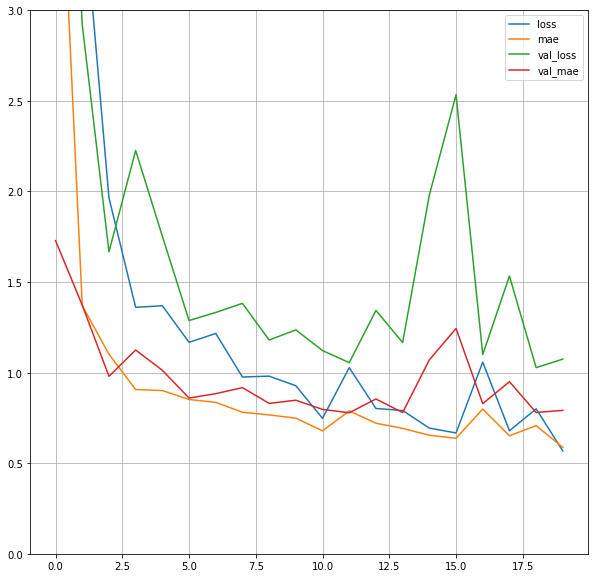

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()
#Convergance achieved on this model

In [ ]:
X_new = X_test
#Sample of the first three values of the first data set

In [ ]:
y_pred = model.predict(X_new)
print(y_pred)
print(y_test[:10])

Multiple Linear Regression


In [29]:
#Using Multiple Linear regression to predict energy demand 

#Selecting dependant and Independant variables  
X = weather_energy[['day'  ,'temperatureMax' , 'windBearing' ,	'dewPoint',
                   'cloudCover',	'windSpeed'	,'pressure'		,
                   'visibility',	'humidity',
                   'uvIndex', 	'sunsetTime',	'temperatureLow',
                   'temperatureMin'	,'temperatureHigh',	'sunriseTime'	,		
                   'moonPhase',	'holiday_ind']].values
y = weather_energy['avg_energy'].values

In [30]:
#BUILD MACHINE LEARNING MODDELS
#BUILD WITH NO TIME/DATE VARIABLES > WITH WEATHER AND WEATHER + HOLIDAY
# USE MULTIPLE TYPES OF REGRESSION


X_regression = weather_energy[['temperatureMax' , 'windBearing' ,	'dewPoint',
                   'cloudCover',	'windSpeed'	,'pressure'		,
                   'visibility',	'humidity',
                   'uvIndex', 		'temperatureLow',
                   'temperatureMin'	,'temperatureHigh',				
                   'moonPhase',	'holiday_ind']].values
y_regression = weather_energy['avg_energy'].values

In [ ]:
#Splitting the dataset into testset and training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
y_train
#THURSDAYS WORK
#EXPLORE TIME SERIES FOR MACHINE LEARNING
#MAKE MODEL WITH TIME SERIES AND TIME AND DATE FUNCTION

In [32]:
#Splitting data into training set and test set
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_regression, y_regression, test_size = 0.2, random_state = 0)


In [34]:
#Training multiple linear regression
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train1, y_train1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#Predicting the test set results
y_pred1 = regressor1.predict(X_test1)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred1.reshape(len(y_pred1),1), y_test1.reshape(len(y_test1),1)),1))

In [ ]:
#Predicting the test set results
y_pred1 = regressor1.predict(X_test1)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred1.reshape(len(y_pred1),1), y_test1.reshape(len(y_test1),1)),1))

In [37]:
X_temperatureMax = weather_energy[['temperatureMax']].values

X_windBearing = weather_energy[['windBearing']].values

X_dewPoint = weather_energy[['dewPoint']].values

X_cloudCover = weather_energy[['cloudCover']].values

X_windSpeed = weather_energy[['windSpeed']].values  

X_pressure = weather_energy[['pressure']].values

X_visibility = weather_energy[['visibility']].values  

X_humidity = weather_energy[['humidity']].values 

X_uvIndex = weather_energy[['uvIndex']].values  

X_temperatureLow = weather_energy[['temperatureLow']].values 

X_temperatureMin = weather_energy[['temperatureMin']].values  

X_temperatureHigh = weather_energy[['temperatureHigh']].values

X_moonPhase = weather_energy[['moonPhase']].values

X_holiday_ind = weather_energy[['holiday_ind']].values

y_regression = weather_energy['avg_energy'].values

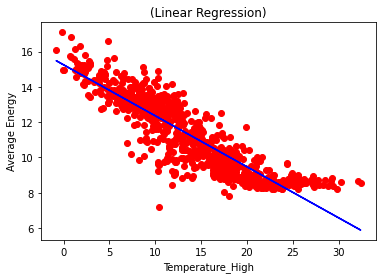

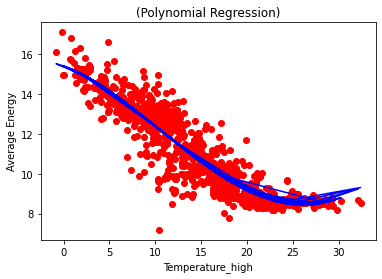

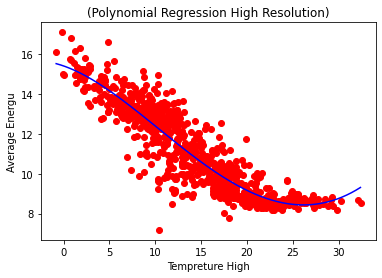

Intercept:  15.254736871816931
Coefficient:  [-0.29]


In [45]:
# Training the Linear Regression model on the whole dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_temperatureHigh, y_regression)


# Training the Polynomial Regression model on the whole dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(X_temperatureHigh)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_regression)

# Visualising the Linear Regression results
plt.scatter(X_temperatureHigh, y_regression, color = 'red')
plt.plot(X_temperatureHigh, lin_reg.predict(X_temperatureHigh), color = 'blue')
plt.title('(Linear Regression)')
plt.xlabel('Temperature_High')
plt.ylabel('Average Energy')
plt.show()

# Visualising the Polynomial Regression results
plt.scatter(X_temperatureHigh, y_regression, color = 'red')
plt.plot(X_temperatureHigh, lin_reg_2.predict(poly_reg.fit_transform(X_temperatureHigh)), color = 'blue')
plt.title('(Polynomial Regression)')
plt.xlabel('Temperature_high')
plt.ylabel('Average Energy')
plt.show()

# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
X_grid = np.arange(min(X_temperatureHigh), max(X_temperatureHigh), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_temperatureHigh, y_regression, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('(Polynomial Regression High Resolution)')
plt.xlabel('Tempreture High')
plt.ylabel('Average Energu')
plt.show()

#PREDICTING AVERAGE ENERGY USED BASED ON TEMPERATURE HIGH
#Predicting a new result with Linear Regression

lin_reg.predict([[38]])

# Predicting a new result with Polynomial Regression
lin_reg_2.predict(poly_reg.fit_transform([[38]]))





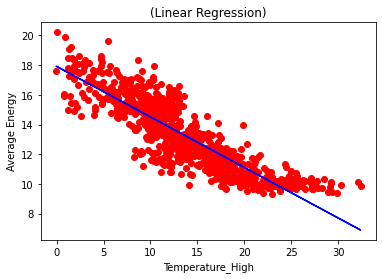

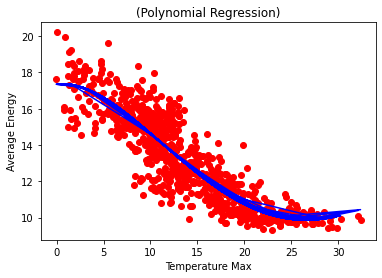

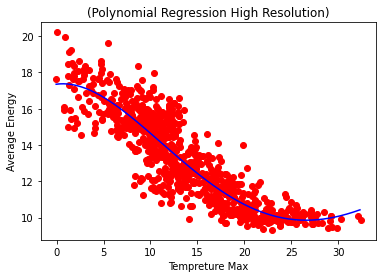

array([9.86])

In [ ]:
#Prediction based on X_temperatureMax
# Training the Linear Regression model on the whole dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_temperatureMax, y_regression)


# Training the Polynomial Regression model on the whole dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(X_temperatureMax)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_regression)

# Visualising the Linear Regression results
plt.scatter(X_temperatureMax, y_regression, color = 'red')
plt.plot(X_temperatureMax, lin_reg.predict(X_temperatureMax), color = 'blue')
plt.title('(Linear Regression)')
plt.xlabel('Temperature_High')
plt.ylabel('Average Energy')
plt.show()

# Visualising the Polynomial Regression results
plt.scatter(X_temperatureMax, y_regression, color = 'red')
plt.plot(X_temperatureMax, lin_reg_2.predict(poly_reg.fit_transform(X_temperatureMax)), color = 'blue')
plt.title('(Polynomial Regression)')
plt.xlabel('Temperature Max')
plt.ylabel('Average Energy')
plt.show()

# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
X_grid = np.arange(min(X_temperatureMax), max(X_temperatureMax), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_temperatureMax, y_regression, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('(Polynomial Regression High Resolution)')
plt.xlabel('Tempreture Max')
plt.ylabel('Average Energy')
plt.show()

#PREDICTING AVERAGE ENERGY USED BASED ON TEMPERATURE HIGH
#Predicting a new result with Linear Regression

lin_reg.predict([[27]])

# Predicting a new result with Polynomial Regression
lin_reg_2.predict(poly_reg.fit_transform([[27]]))

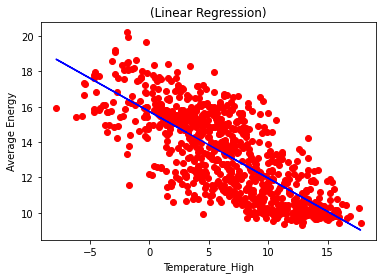

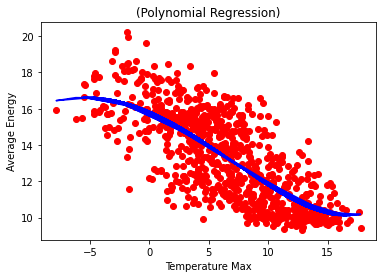

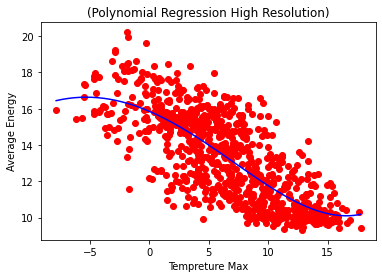

array([18.76])

In [ ]:
#Prediction based on Dew point
# Training the Linear Regression model on the whole dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_dewPoint, y_regression)


# Training the Polynomial Regression model on the whole dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(X_dewPoint)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_regression)

# Visualising the Linear Regression results
plt.scatter(X_dewPoint, y_regression, color = 'red')
plt.plot(X_dewPoint, lin_reg.predict(X_dewPoint), color = 'blue')
plt.title('(Linear Regression)')
plt.xlabel('Temperature_High')
plt.ylabel('Average Energy')
plt.show()

# Visualising the Polynomial Regression results
plt.scatter(X_dewPoint, y_regression, color = 'red')
plt.plot(X_dewPoint, lin_reg_2.predict(poly_reg.fit_transform(X_dewPoint)), color = 'blue')
plt.title('(Polynomial Regression)')
plt.xlabel('Temperature Max')
plt.ylabel('Average Energy')
plt.show()

# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
X_grid = np.arange(min(X_dewPoint), max(X_dewPoint), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_dewPoint, y_regression, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('(Polynomial Regression High Resolution)')
plt.xlabel('Tempreture Max')
plt.ylabel('Average Energy')
plt.show()

#PREDICTING AVERAGE ENERGY USED BASED ON TEMPERATURE HIGH
#Predicting a new result with Linear Regression

lin_reg.predict([[27]])

# Predicting a new result with Polynomial Regression
lin_reg_2.predict(poly_reg.fit_transform([[27]]))

In [ ]:
y_regression = y.reshape(len(y),1)
print(y)

#SVR REGRESSION

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_temperatureHigh)
y = sc_y.fit_transform(y_regression)
print(X)
print(y)

# Training the SVR model on the whole dataset
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

# Predicting a new result
sc_y.inverse_transform(regressor.predict(sc_X.transform([[6.5]])))

# Visualising the SVR results
plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y), color = 'red')
plt.plot(sc_X.inverse_transform(X), sc_y.inverse_transform(regressor.predict(X)), color = 'blue')
plt.title('Energy and Temp (SVR)')
plt.xlabel('Temp')
plt.ylabel('Average Energy')
plt.show()

# Visualising the SVR results (for higher resolution and smoother curve)
X_grid = np.arange(min(sc_X.inverse_transform(X)), max(sc_X.inverse_transform(X)), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y), color = 'red')
plt.plot(X_grid, sc_y.inverse_transform(regressor.predict(sc_X.transform(X_grid))), color = 'blue')
plt.title('Energy and Temp (SVR)')
plt.xlabel('Temp')
plt.ylabel('Average Energy')
plt.show()

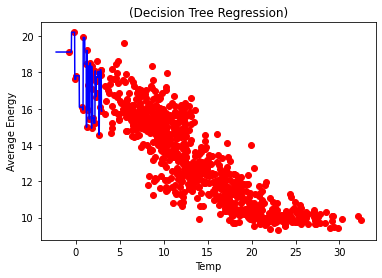

In [ ]:
#DECISION TREE REGRESSION

# Training the Decision Tree Regression model on the whole dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_temperatureHigh, y_regression)

# Predicting a new result
regressor.predict([[21]])

# Visualising the Decision Tree Regression results (higher resolution)
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_temperatureHigh, y_regression, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('(Decision Tree Regression)')
plt.xlabel('Temp')
plt.ylabel('Average Energy')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


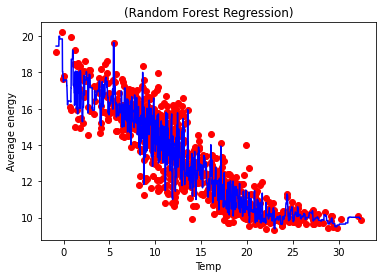

In [ ]:
#RANDOM FOREST 

# Training the Random Forest Regression model on the whole dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_temperatureHigh, y_regression)

# Predicting a new result
regressor.predict([[6.5]])

# Visualising the Random Forest Regression results (higher resolution)
X_grid = np.arange(min(X_temperatureHigh), max(X_temperatureHigh), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_temperatureHigh, y_regression, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('(Random Forest Regression)')
plt.xlabel('Temp')
plt.ylabel('Average energy')
plt.show()

Neural Network

In [ ]:
X_Nueral = weather_energy[['temperatureMax' , 'windBearing' ,	'dewPoint',
                   'cloudCover',	'windSpeed'	,'pressure'		,
                   'visibility',	'humidity',
                   'uvIndex', 		'temperatureLow',
                   'temperatureMin'	,'temperatureHigh',				
                   'moonPhase', 'avg_energy']].values
y_Nueral = weather_energy['holiday_ind'].values

In [ ]:
#BUILD NEURAL NETWORK MODEL
# ANN MODEL IS ABLE TO DETERMINE IF THERE IS HOLIDAY OR NOT BASED ON INFORMATION

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Nueral, y_Nueral, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:
import tensorflow as tf
tf.__version__

# Part 2 - Building the ANN

# Initializing the ANN
ann = tf.keras.models.Sequential()

# Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Adding the output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Part 3 - Training the ANN

# Compiling the ANN
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the ANN on the Training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6885 - accuracy: 0.5468
Epoch 2/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6560 - accuracy: 0.6073
Epoch 3/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6391 - accuracy: 0.6571
Epoch 4/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6284 - accuracy: 0.6918
Epoch 5/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6222 - accuracy: 0.7069
Epoch 6/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6182 - accuracy: 0.6964
Epoch 7/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6154 - accuracy: 0.6979
Epoch 8/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6131 - accuracy: 0.6964
Epoch 9/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6115 - accuracy: 0.6964
Epoch 10/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6101 - accuracy: 0.6964
Epoch 11/

In [ ]:
# Part 4 - Making the predictions and evaluating the model

# Predicting the result of a single observation

"""
Using the ANN model to predict what the average energy usage will be based on these weather factors: 
TemperatureMax: 21
Wind Bearing: 237
DewPoint: 7.5
CloudCover: 0.45
WindSpeed: 5.75
pressure:  1011.25
visibility: 12.34
Humidity: 0.73
uvIndex: 2.0
temperatureLow: 11
TemperatureMin: 13
TemperatureHigh: 22
moonPhase: 0.86
avg_energy: 10.5 


Expected average energy used based on ANN:
"""

print(ann.predict(sc.transform([[22, 209, 6.8, 0.2, 2.6, 1011.25, 16.5, 1.1, 4.0, 27, 14, 32, 0.86, 14]]))) # > 0.5)

#Probability that it is a bank holiday is 19%

[[0.57]]


In [ ]:
# Predicting the Test set results
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[103  10]
 [ 51   2]]


0.6325301204819277

KNN model

In [ ]:
# Splitting the dataset into the Training set and Test set
# KNN model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Nueral, y_Nueral, test_size = 0.25, random_state = 0)
print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[2.73e+01 1.19e+02 1.39e+01 ... 2.73e+01 6.70e-01 9.67e+00]
 [2.20e+01 2.92e+02 9.32e+00 ... 2.20e+01 4.40e-01 1.03e+01]
 [1.14e+01 2.18e+02 6.63e+00 ... 1.14e+01 2.20e-01 1.51e+01]
 ...
 [2.04e+01 2.81e+02 8.99e+00 ... 2.04e+01 1.80e-01 1.00e+01]
 [1.87e+01 6.20e+01 6.34e+00 ... 1.87e+01 8.40e-01 1.12e+01]
 [1.92e+01 2.37e+02 1.04e+01 ... 1.92e+01 5.00e-02 1.19e+01]]
[0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1
 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1
 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 1 0 1

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)
print(X_test)

[[ 2.16 -0.89  1.52 ...  2.15  0.58 -1.47]
 [ 1.32  1.04  0.57 ...  1.32 -0.22 -1.22]
 [-0.37  0.21  0.02 ... -0.35 -0.99  0.74]
 ...
 [ 1.06  0.92  0.51 ...  1.07 -1.13 -1.33]
 [ 0.79 -1.53 -0.04 ...  0.8   1.17 -0.85]
 [ 0.87  0.42  0.79 ...  0.88 -1.58 -0.57]]
[[ 1.44  0.69  0.87 ...  1.44 -1.23 -1.44]
 [-0.69  1.33 -1.37 ... -0.66 -0.36  0.39]
 [-0.25  0.29  0.07 ... -0.22 -0.99 -0.41]
 ...
 [ 0.44  0.98  0.63 ...  0.45 -1.2  -0.7 ]
 [ 0.02  0.65  0.49 ...  0.04 -1.02 -0.17]
 [ 1.03 -1.08  1.67 ...  1.04 -0.39 -1.17]]


In [ ]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Predicting a new result
print(classifier.predict(sc.transform([[5, 187, 6.8, 0.45, 5.75, 1011.25, 12.34, 0.73, 4.0, 11, 5, 35, 0.86, 15]])))


[0]


In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [1 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[126  14]
 [ 60   7]]


0.642512077294686

SVM

In [ ]:
# Training the SVM model on the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting a new result
print(classifier.predict(sc.transform([[5, 187, 6.8, 0.45, 5.75, 1011.25, 12.34, 0.73, 4.0, 11, 5, 35, 0.86, 15]])))


[0]


In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))


[[0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[140   0]
 [ 67   0]]


0.6763285024154589

In [ ]:
# Training the Logistic Regression model on the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting a new result
print(classifier.predict(sc.transform([[5, 187, 6.8, 0.45, 5.75, 1011.25, 12.34, 0.73, 4.0, 11, 5, 35, 0.86, 15]])))

[1]


In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]

0.6859903381642513

Time series

In [ ]:

weather_energy.to_csv('weather_energy.csv', index=False)


In [ ]:
ls

Bank_holidays_new.xlsx  sample_data/               weather_energy.csv
energy.csv              weather_daily_darksky.csv


In [ ]:
#Loading weather_energy data as time series

series = pd.read_csv('weather_energy.csv', header=0, parse_dates=[0], squeeze = True)
series.tail()

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind
823,2014-02-23,15919.398999,1070,14.877943,11.94,2014-02-23,200,wind,6.17,2014-02-23,0.66,7.10,1010.37,2014-02-23,11.94,rain,12.33,0.76,2014-02-23,5.52,11.94,1.0,2014-02-23,2014-02-23,7.99,8.67,11.94,2014-02-23,2014-02-23 16:00:00,2014-02-23,Mostly cloudy until evening and breezy until a...,2014-02-24,5.53,2014-02-23,2014-02-24,0.78,2014-02-23,1
824,2014-02-24,14667.951999,1069,13.721190,14.23,2014-02-24,183,wind,6.03,2014-02-24,0.50,5.02,1005.19,2014-02-24,14.23,rain,13.00,0.74,2014-02-24,4.78,14.23,1.0,2014-02-24,2014-02-24,8.25,7.99,14.23,2014-02-24,2014-02-24 13:00:00,2014-02-24,Mostly cloudy until evening and breezy overnight.,2014-02-25,5.52,2014-02-24,2014-02-25,0.82,NaN,0
825,2014-02-25,14663.856997,1070,13.704539,11.43,2014-02-25,202,partly-cloudy-day,5.06,2014-02-25,0.62,5.69,1000.65,2014-02-25,10.31,rain,12.09,0.78,2014-02-25,1.67,11.43,1.0,2014-02-25,2014-02-25,4.17,6.79,10.31,2014-02-25,2014-02-25 14:00:00,2014-02-25,Mostly cloudy throughout the day.,2014-02-26,3.89,2014-02-25,2014-02-26,0.86,NaN,0
826,2014-02-26,14359.677000,1070,13.420259,11.29,2014-02-26,227,partly-cloudy-day,2.74,2014-02-26,0.26,3.82,1012.73,2014-02-26,11.29,rain,13.00,0.73,2014-02-26,3.03,11.29,2.0,2014-02-26,2014-02-26,6.01,4.17,11.29,2014-02-26,2014-02-26 13:00:00,2014-02-26,Partly cloudy throughout the day.,2014-02-27,1.67,2014-02-26,2014-02-27,0.90,NaN,0
827,2014-02-27,14722.842997,1069,13.772538,10.31,2014-02-27,224,partly-cloudy-day,3.08,2014-02-27,0.32,4.14,1007.02,2014-02-27,10.31,rain,12.04,0.74,2014-02-27,0.82,10.31,2.0,2014-02-27,2014-02-27,3.43,3.93,10.31,2014-02-27,2014-02-27 14:00:00,2014-02-27,Partly cloudy until evening.,2014-02-28,1.41,2014-02-27,2014-02-28,0.93,NaN,0


In [ ]:
#remove last row which contains ang_energy outlier once more
#still remains from last download

#series = series.drop(828)

In [ ]:
#exploring time series

series.shape

(828, 38)

In [ ]:
series.head(5)

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind
0,2011-11-23,46.206,4,11.551500,10.36,2011-11-23,229,fog,6.29,2011-11-23,0.36,2.04,1027.12,2011-11-23,10.36,rain,8.06,0.93,2011-11-23,6.56,10.36,1.0,2011-11-23,2011-11-23,8.24,3.81,10.36,2011-11-23,2011-11-23 14:00:00,2011-11-23,Foggy in the morning.,2011-11-23,2.18,2011-11-23,2011-11-23,0.94,2011-11-23,1
1,2011-11-24,98.746,8,12.343250,12.93,2011-11-24,204,partly-cloudy-night,8.56,2011-11-24,0.41,4.04,1027.22,2011-11-24,12.93,rain,10.64,0.89,2011-11-24,7.30,12.93,1.0,2011-11-24,2011-11-24,9.71,8.56,12.93,2011-11-24,2011-11-24 12:00:00,2011-11-24,Partly cloudy throughout the day.,2011-11-24,7.01,2011-11-24,2011-11-24,0.97,NaN,0
2,2011-11-25,127.173,9,14.130333,13.03,2011-11-25,243,partly-cloudy-day,7.24,2011-11-25,0.48,5.02,1024.47,2011-11-25,12.27,rain,12.38,0.79,2011-11-25,4.69,13.03,1.0,2011-11-25,2011-11-25,7.01,7.46,12.27,2011-11-25,2011-11-25 12:00:00,2011-11-25,Partly cloudy throughout the day.,2011-11-26,4.84,2011-11-25,2011-11-26,0.01,NaN,0
3,2011-11-26,142.337,9,15.815222,12.96,2011-11-26,237,wind,6.96,2011-11-26,0.44,5.75,1025.80,2011-11-26,12.96,rain,13.07,0.81,2011-11-26,11.59,12.96,1.0,2011-11-26,2011-11-26,11.59,7.01,12.96,2011-11-26,2011-11-26 14:00:00,2011-11-26,Mostly cloudy throughout the day and breezy ov...,2011-11-26,4.69,2011-11-26,2011-11-26,0.05,2011-11-26,1
4,2011-11-27,143.551,9,15.950111,13.54,2011-11-27,256,wind,5.76,2011-11-27,0.42,5.48,1021.11,2011-11-27,13.54,rain,13.08,0.72,2011-11-27,1.31,13.54,1.0,2011-11-27,2011-11-27,1.31,4.47,13.54,2011-11-27,2011-11-27 10:00:00,2011-11-27,Breezy in the morning and partly cloudy until ...,2011-11-28,2.94,2011-11-27,2011-11-28,0.08,2011-11-27,1


In [ ]:
series['day'].dtype

dtype('<M8[ns]')

In [ ]:
series[(series['day'] > '2011-11-26') & (series['day'] <= '2011-12-20')]

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind
4,2011-11-27,143.551000,9,15.950111,13.54,2011-11-27,256,wind,5.76,2011-11-27,0.42,5.48,1021.11,2011-11-27,13.54,rain,13.08,0.72,2011-11-27,1.31,13.54,1.0,2011-11-27,2011-11-27,1.31,4.47,13.54,2011-11-27,2011-11-27 10:00:00,2011-11-27,Breezy in the morning and partly cloudy until ...,2011-11-28,2.94,2011-11-27,2011-11-28,0.08,2011-11-27,1
5,2011-11-28,178.682000,14,12.763000,12.58,2011-11-28,190,partly-cloudy-night,4.39,2011-11-28,0.56,2.34,1022.80,2011-11-28,10.27,rain,11.84,0.86,2011-11-28,10.27,12.58,1.0,2011-11-28,2011-11-28,10.27,1.31,10.27,2011-11-28,2011-11-28 19:00:00,2011-11-28,Mostly cloudy throughout the day.,2011-11-28,1.31,2011-11-28,2011-11-28,0.12,NaN,0
6,2011-11-29,199.678000,16,12.479875,13.47,2011-11-29,213,wind,8.61,2011-11-29,0.60,6.48,1009.70,2011-11-29,13.47,rain,12.57,0.82,2011-11-29,3.34,13.47,1.0,2011-11-29,2011-11-29,6.34,6.37,13.47,2011-11-29,2011-11-29 14:00:00,2011-11-29,Mostly cloudy until evening and breezy startin...,2011-11-30,3.39,2011-11-29,2011-11-30,0.15,NaN,0
7,2011-11-30,225.638000,20,11.281900,11.87,2011-11-30,205,wind,5.26,2011-11-30,0.31,4.43,1019.43,2011-11-30,11.87,rain,13.05,0.78,2011-11-30,6.23,11.87,1.0,2011-11-30,2011-11-30,9.44,6.34,11.87,2011-11-30,2011-11-30 12:00:00,2011-11-30,Partly cloudy throughout the day and breezy ov...,2011-12-01,3.34,2011-11-30,2011-12-01,0.19,NaN,0
8,2011-12-01,307.023000,25,12.280920,12.15,2011-12-01,225,partly-cloudy-day,6.87,2011-12-01,0.57,2.57,1007.12,2011-12-01,12.15,rain,12.15,0.82,2011-12-01,0.46,12.15,1.0,2011-12-01,2011-12-01,2.56,6.08,12.15,2011-12-01,2011-12-01 07:00:00,2011-12-01,Partly cloudy throughout the day.,2011-12-02,5.29,2011-12-01,2011-12-02,0.22,NaN,0
9,2011-12-02,347.758000,25,13.910320,8.07,2011-12-02,232,wind,3.69,2011-12-02,0.32,3.00,1012.12,2011-12-02,5.33,rain,11.89,0.87,2011-12-02,3.26,5.33,1.0,2011-12-02,2011-12-02,6.33,2.56,7.36,2011-12-02,2011-12-02 12:00:00,2011-12-02,Partly cloudy throughout the day and breezy ov...,2011-12-02,0.46,2011-12-02,2011-12-02,0.25,NaN,0
10,2011-12-03,392.298000,27,14.529556,11.42,2011-12-03,247,partly-cloudy-day,6.58,2011-12-03,0.54,5.42,1003.55,2011-12-03,11.42,rain,12.70,0.79,2011-12-03,4.90,11.42,1.0,2011-12-03,2011-12-03,7.53,8.12,11.42,2011-12-03,2011-12-03 10:00:00,2011-12-03,Partly cloudy throughout the day.,2011-12-04,4.71,2011-12-03,2011-12-04,0.28,2011-12-03,1
11,2011-12-04,437.202001,27,16.192667,9.11,2011-12-04,254,partly-cloudy-day,4.87,2011-12-04,0.36,4.31,1001.15,2011-12-04,6.66,rain,13.36,0.82,2011-12-04,-1.69,6.66,1.0,2011-12-04,2011-12-04,2.81,4.69,9.11,2011-12-04,2011-12-04 13:00:00,2011-12-04,Partly cloudy until evening.,2011-12-05,1.03,2011-12-04,2011-12-05,0.31,2011-12-04,1
12,2011-12-05,415.180000,28,14.827857,6.87,2011-12-05,254,partly-cloudy-day,0.84,2011-12-05,0.20,5.57,1006.01,2011-12-05,3.13,rain,13.00,0.77,2011-12-05,-1.61,3.13,1.0,2011-12-05,2011-12-05,2.68,2.81,6.87,2011-12-05,2011-12-05 13:00:00,2011-12-05,Partly cloudy until evening.,2011-12-06,-1.69,2011-12-05,2011-12-06,0.34,NaN,0
13,2011-12-06,505.941000,30,16.864700,6.91,2011-12-06,245,partly-cloudy-day,2.15,2011-12-06,0.34,4.79,1007.32,2011-12-06,3.77,rain,13.15,0.83,2011-12-06,1.90,3.77,1.0,2011-12-06,2011-12-06,5.16,2.68,6.91,2011-12-06,2011-12-06 14:00:00,2011-12-06,Partly cloudy until evening.,2011-12-06,-1.61,2011-12-06,2011-12-06,0.37,NaN,0


In [ ]:
series.describe()

,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,holiday_ind
count,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000
mean,12271.247621,927.689614,13.260674,13.691981,198.078502,6.548623,0.479457,3.602295,1014.078527,12.714517,11.299408,0.780386,6.149444,12.927271,2.595411,7.773647,7.456389,13.570338,5.774287,0.500882,0.306763
std,5808.960378,374.153040,2.455676,6.331549,88.998253,4.918712,0.191461,1.708470,11.098725,7.459057,2.321070,0.094698,6.156721,7.281027,1.866611,4.963111,4.986009,6.411166,6.174516,0.287728,0.461429
min,46.206000,4.000000,9.323391,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000,0.000000
25%,9114.959250,818.750000,11.026397,9.327500,130.750000,3.125000,0.350000,2.370000,1007.427500,6.647500,10.555000,0.720000,1.452500,7.177500,1.000000,3.980000,3.655000,9.107500,1.077500,0.250000,0.000000
50%,13036.481001,1115.500000,13.084075,12.580000,221.000000,6.440000,0.470000,3.470000,1014.445000,12.440000,12.040000,0.790000,5.410000,12.580000,2.000000,7.550000,7.075000,12.440000,4.905000,0.500000,0.000000
75%,16804.198001,1166.000000,15.306344,18.097500,256.000000,10.222500,0.600000,4.600000,1021.630000,18.090000,12.860000,0.850000,11.652500,18.122500,4.000000,11.652500,11.462500,18.082500,11.462500,0.750000,1.000000
max,24150.159000,1206.000000,20.209338,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000,1.000000


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

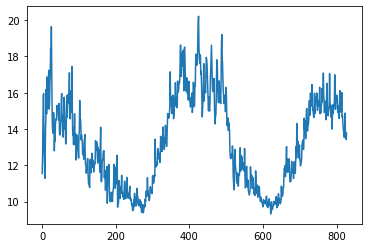

In [ ]:
series['avg_energy'].plot()


Plotting time series chart

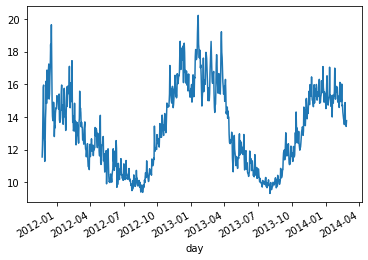

In [ ]:
#change index to the date column
series.index = series['day']
#plot now with date as index
series['avg_energy'].plot()
#average energy at yaxis day at xaxis


plotting time series for particular time interval

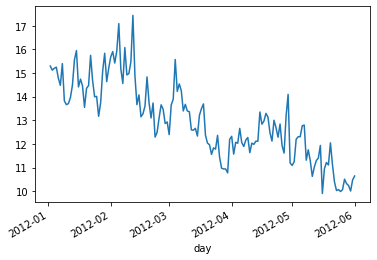

In [ ]:
#zooming in for particular time interval
#showing energy usage from winter to summer for the year 2012
winter_summer_012 = series[(series['day'] > '2012-01-01') & (series['day'] <= '2012-06-01')].copy()
winter_summer_012['avg_energy'].plot()


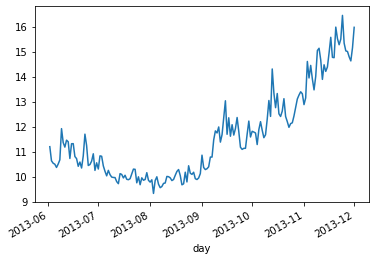

In [ ]:
#showing energy usage from summer to winter for the year 2013
summer_winter_013 = series[(series['day'] > '2013-06-01') & (series['day'] <= '2013-12-01')].copy()
summer_winter_013['avg_energy'].plot()

Exploring trendlines

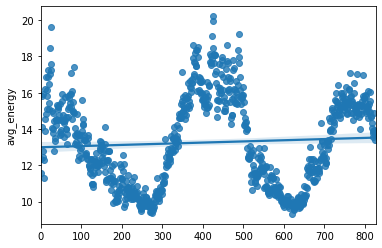

In [ ]:
import seaborn as sns
series_2 = pd.read_csv('weather_energy.csv', header=0, parse_dates=[0], squeeze = True)
sns.regplot(x = series_2.index.values, y = series_2['avg_energy'])
#graph with first oder trendline

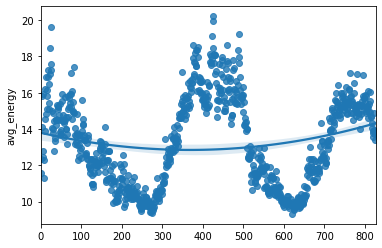

In [ ]:
sns.regplot(x = series_2.index.values, y = series_2['avg_energy'], order = 2)
#graph with second order trendline (quadratic)

Exploring seasonality in data set

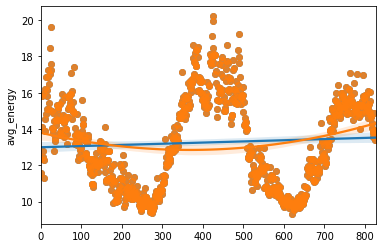

In [ ]:
import seaborn as sns
series_2 = pd.read_csv('weather_energy.csv', header=0, parse_dates=[0], squeeze = True)
sns.regplot(x = series_2.index.values, y=series_2['avg_energy'])
sns.regplot(x = series_2.index.values, y=series_2['avg_energy'], order = 2)
#up and down trend shows seasonality

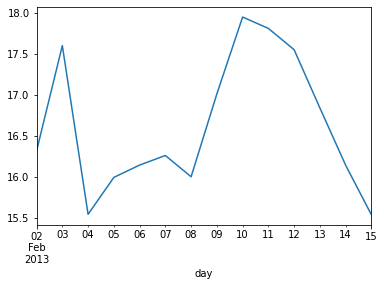

In [ ]:
#showing changes in energy usage within a given week
two_week_change = series[(series['day'] > '2013-02-01') & (series['day'] <= '2013-02-15')].copy()
two_week_change['avg_energy'].plot()
#as shown energy usage peaks on 02 and 03 Feb which are weekends and peaks the following weekend

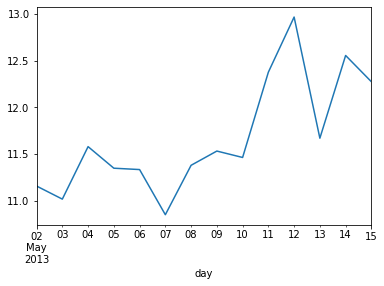

In [ ]:
two_week_change_2 = series[(series['day'] > '2013-05-01') & (series['day'] <= '2013-05-15')].copy()
two_week_change_2['avg_energy'].plot()
#peak energy usage between 11 and 12 May which are also weekends

Creating lag plots

In [ ]:
series_2['lag1'] = series_2['avg_energy'].shift(1)
#shifts all the values by one time period
series_2.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind,lag1
0,2011-11-23,46.206,4,11.551500,10.36,2011-11-23,229,fog,6.29,2011-11-23,0.36,2.04,1027.12,2011-11-23,10.36,rain,8.06,0.93,2011-11-23,6.56,10.36,1.0,2011-11-23,2011-11-23,8.24,3.81,10.36,2011-11-23,2011-11-23 14:00:00,2011-11-23,Foggy in the morning.,2011-11-23,2.18,2011-11-23,2011-11-23,0.94,2011-11-23,1,NaN
1,2011-11-24,98.746,8,12.343250,12.93,2011-11-24,204,partly-cloudy-night,8.56,2011-11-24,0.41,4.04,1027.22,2011-11-24,12.93,rain,10.64,0.89,2011-11-24,7.30,12.93,1.0,2011-11-24,2011-11-24,9.71,8.56,12.93,2011-11-24,2011-11-24 12:00:00,2011-11-24,Partly cloudy throughout the day.,2011-11-24,7.01,2011-11-24,2011-11-24,0.97,NaN,0,11.551500
2,2011-11-25,127.173,9,14.130333,13.03,2011-11-25,243,partly-cloudy-day,7.24,2011-11-25,0.48,5.02,1024.47,2011-11-25,12.27,rain,12.38,0.79,2011-11-25,4.69,13.03,1.0,2011-11-25,2011-11-25,7.01,7.46,12.27,2011-11-25,2011-11-25 12:00:00,2011-11-25,Partly cloudy throughout the day.,2011-11-26,4.84,2011-11-25,2011-11-26,0.01,NaN,0,12.343250
3,2011-11-26,142.337,9,15.815222,12.96,2011-11-26,237,wind,6.96,2011-11-26,0.44,5.75,1025.80,2011-11-26,12.96,rain,13.07,0.81,2011-11-26,11.59,12.96,1.0,2011-11-26,2011-11-26,11.59,7.01,12.96,2011-11-26,2011-11-26 14:00:00,2011-11-26,Mostly cloudy throughout the day and breezy ov...,2011-11-26,4.69,2011-11-26,2011-11-26,0.05,2011-11-26,1,14.130333
4,2011-11-27,143.551,9,15.950111,13.54,2011-11-27,256,wind,5.76,2011-11-27,0.42,5.48,1021.11,2011-11-27,13.54,rain,13.08,0.72,2011-11-27,1.31,13.54,1.0,2011-11-27,2011-11-27,1.31,4.47,13.54,2011-11-27,2011-11-27 10:00:00,2011-11-27,Breezy in the morning and partly cloudy until ...,2011-11-28,2.94,2011-11-27,2011-11-28,0.08,2011-11-27,1,15.815222


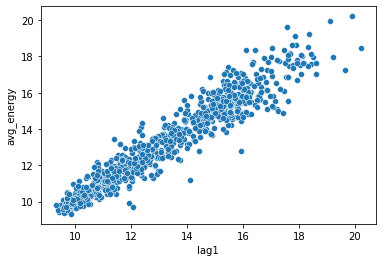

In [ ]:
sns.scatterplot(x=series_2['lag1'], y=series_2['avg_energy'])
#positive correlation between the lagged values

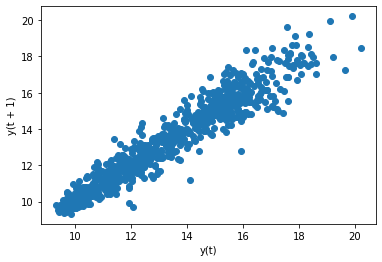

In [ ]:
#alternative version of doing the same thing
from pandas.plotting import lag_plot
lag_plot(series_2['avg_energy'])


Autocorrelation plots

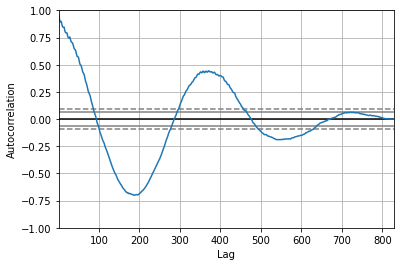

In [ ]:
from pandas.plotting import  autocorrelation_plot
autocorrelation_plot(series_2['avg_energy'])
#shows correlation between variables and its lag
#around every month the is a dip in correlation values
#this is due to seasonality over the year and slight ones over a week
#lows and high in autocorrelation is expected for seasonal data

Test Train split for this time series

In [ ]:
series_2.shape[0]
#observing the amount of rows of data

828

In [ ]:
train_size = int(series_2.shape[0]*0.8)
train_size
#observing the amount of training data
#80% for training size

662

In [ ]:
#slicing the data for training and test set
#training and test set cannot be selected at random for time series
train = series_2[0:train_size]
test = series_2[train_size:]

In [ ]:
series_2.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind,lag1
0,2011-11-23,46.206,4,11.551500,10.36,2011-11-23,229,fog,6.29,2011-11-23,0.36,2.04,1027.12,2011-11-23,10.36,rain,8.06,0.93,2011-11-23,6.56,10.36,1.0,2011-11-23,2011-11-23,8.24,3.81,10.36,2011-11-23,2011-11-23 14:00:00,2011-11-23,Foggy in the morning.,2011-11-23,2.18,2011-11-23,2011-11-23,0.94,2011-11-23,1,NaN
1,2011-11-24,98.746,8,12.343250,12.93,2011-11-24,204,partly-cloudy-night,8.56,2011-11-24,0.41,4.04,1027.22,2011-11-24,12.93,rain,10.64,0.89,2011-11-24,7.30,12.93,1.0,2011-11-24,2011-11-24,9.71,8.56,12.93,2011-11-24,2011-11-24 12:00:00,2011-11-24,Partly cloudy throughout the day.,2011-11-24,7.01,2011-11-24,2011-11-24,0.97,NaN,0,11.551500
2,2011-11-25,127.173,9,14.130333,13.03,2011-11-25,243,partly-cloudy-day,7.24,2011-11-25,0.48,5.02,1024.47,2011-11-25,12.27,rain,12.38,0.79,2011-11-25,4.69,13.03,1.0,2011-11-25,2011-11-25,7.01,7.46,12.27,2011-11-25,2011-11-25 12:00:00,2011-11-25,Partly cloudy throughout the day.,2011-11-26,4.84,2011-11-25,2011-11-26,0.01,NaN,0,12.343250
3,2011-11-26,142.337,9,15.815222,12.96,2011-11-26,237,wind,6.96,2011-11-26,0.44,5.75,1025.80,2011-11-26,12.96,rain,13.07,0.81,2011-11-26,11.59,12.96,1.0,2011-11-26,2011-11-26,11.59,7.01,12.96,2011-11-26,2011-11-26 14:00:00,2011-11-26,Mostly cloudy throughout the day and breezy ov...,2011-11-26,4.69,2011-11-26,2011-11-26,0.05,2011-11-26,1,14.130333
4,2011-11-27,143.551,9,15.950111,13.54,2011-11-27,256,wind,5.76,2011-11-27,0.42,5.48,1021.11,2011-11-27,13.54,rain,13.08,0.72,2011-11-27,1.31,13.54,1.0,2011-11-27,2011-11-27,1.31,4.47,13.54,2011-11-27,2011-11-27 10:00:00,2011-11-27,Breezy in the morning and partly cloudy until ...,2011-11-28,2.94,2011-11-27,2011-11-28,0.08,2011-11-27,1,15.815222


Naive forcast model

In [ ]:
Naive_train_X, Naive_train_y = train['lag1'], train['avg_energy']
Naive_test_X, Naive_test_y = test['lag1'], test['avg_energy']



In [ ]:
#walk forward validation

predictions = Naive_test_X.copy()

In [ ]:
print(predictions)
print(Naive_test_y)
#miniture forcast model for data

662    11.376418
663    11.677649
664    12.333922
665    13.030786
666    11.689819
         ...    
823    13.931229
824    14.877943
825    13.721190
826    13.704539
827    13.420259
Name: lag1, Length: 166, dtype: float64
662    11.677649
663    12.333922
664    13.030786
665    11.689819
666    12.350300
         ...    
823    14.877943
824    13.721190
825    13.704539
826    13.420259
827    13.772538
Name: avg_energy, Length: 166, dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Naive_test_y, predictions)
mse
#mse is the square root of the differences between actual value and predicted value
#if advanced model gives mse value greater than this we can consider out model unable to extract information from data

0.4212846146914589

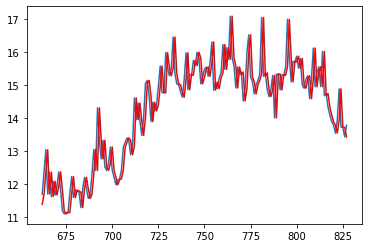

In [ ]:
from matplotlib import  pyplot
pyplot.plot(Naive_test_y)
pyplot.plot(predictions, color='red')

In [ ]:
del series_2['lag1']
#remove lag as it is no longer needed

In [ ]:
series_2.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind
0,2011-11-23,46.206,4,11.551500,10.36,2011-11-23,229,fog,6.29,2011-11-23,0.36,2.04,1027.12,2011-11-23,10.36,rain,8.06,0.93,2011-11-23,6.56,10.36,1.0,2011-11-23,2011-11-23,8.24,3.81,10.36,2011-11-23,2011-11-23 14:00:00,2011-11-23,Foggy in the morning.,2011-11-23,2.18,2011-11-23,2011-11-23,0.94,2011-11-23,1
1,2011-11-24,98.746,8,12.343250,12.93,2011-11-24,204,partly-cloudy-night,8.56,2011-11-24,0.41,4.04,1027.22,2011-11-24,12.93,rain,10.64,0.89,2011-11-24,7.30,12.93,1.0,2011-11-24,2011-11-24,9.71,8.56,12.93,2011-11-24,2011-11-24 12:00:00,2011-11-24,Partly cloudy throughout the day.,2011-11-24,7.01,2011-11-24,2011-11-24,0.97,NaN,0
2,2011-11-25,127.173,9,14.130333,13.03,2011-11-25,243,partly-cloudy-day,7.24,2011-11-25,0.48,5.02,1024.47,2011-11-25,12.27,rain,12.38,0.79,2011-11-25,4.69,13.03,1.0,2011-11-25,2011-11-25,7.01,7.46,12.27,2011-11-25,2011-11-25 12:00:00,2011-11-25,Partly cloudy throughout the day.,2011-11-26,4.84,2011-11-25,2011-11-26,0.01,NaN,0
3,2011-11-26,142.337,9,15.815222,12.96,2011-11-26,237,wind,6.96,2011-11-26,0.44,5.75,1025.80,2011-11-26,12.96,rain,13.07,0.81,2011-11-26,11.59,12.96,1.0,2011-11-26,2011-11-26,11.59,7.01,12.96,2011-11-26,2011-11-26 14:00:00,2011-11-26,Mostly cloudy throughout the day and breezy ov...,2011-11-26,4.69,2011-11-26,2011-11-26,0.05,2011-11-26,1
4,2011-11-27,143.551,9,15.950111,13.54,2011-11-27,256,wind,5.76,2011-11-27,0.42,5.48,1021.11,2011-11-27,13.54,rain,13.08,0.72,2011-11-27,1.31,13.54,1.0,2011-11-27,2011-11-27,1.31,4.47,13.54,2011-11-27,2011-11-27 10:00:00,2011-11-27,Breezy in the morning and partly cloudy until ...,2011-11-28,2.94,2011-11-27,2011-11-28,0.08,2011-11-27,1


ARIMA model

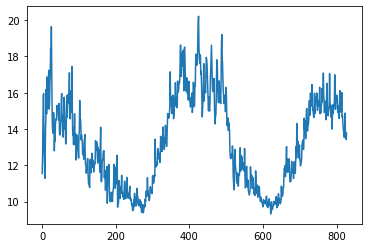

In [ ]:
series_2['avg_energy'].plot()
#This indicates that there is a somewhat quadratic plot 
#in ARIMA model D = 2 is used, not D =1 as that is linear

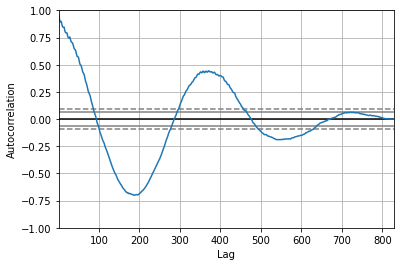

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series_2['avg_energy'])
#data for about 800 valies
#correlation value with each lag decreases and increases
#confidence interval shown with the two bands
#First confidence interval crossed at around lag 80-100, hence that is the range for the q value

Partial autocorrelation graph

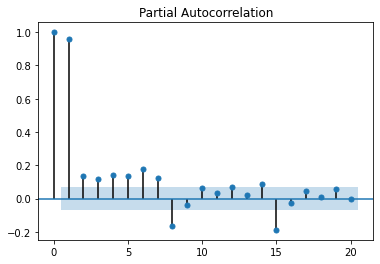

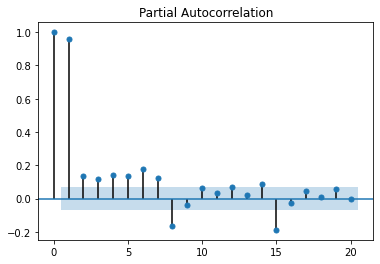

In [ ]:
from statsmodels.graphics.tsaplots import  plot_pacf
plot_pacf(series_2['avg_energy'], lags = 20) #consider 20 lags for this 
#consider 7 as P since that is before it crosses the confidence interval

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

#d = 2, q = 80, p = 7
model = ARIMA(pd.DataFrame(series_2['avg_energy']), order = (7,2,3)) # order in p,d,q
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: Converge

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D2.avg_energy   No. Observations:                  826
Model:                 ARIMA(7, 2, 3)   Log Likelihood                -803.785
Method:                       css-mle   S.D. of innovations              0.637
Date:                Thu, 19 Aug 2021   AIC                           1631.571
Time:                        17:36:28   BIC                           1688.170
Sample:                             2   HQIC                          1653.281
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.838e-06   4.74e-05      0.039      0.969    -9.1e-05    9.47e-05
ar.L1.D2.avg_energy    -0.7002      0.083     -8.419      0.000      -0.863      -0.537
ar.L2.D2.avg_energy    -1.0895      0.084    -12.932      0.000      -1.255      -0.924
ar.L3.D2.avg_energy    -0.4701      0.062     -7.599      0.000      -0.591      -0.349
ar.L4.D2.avg_energy    -0.4309      0.062     -6.931      0.000      -0.553      -0.309
ar.L5.D2.avg_energy    -0.4326      0.062     -7.024      0.000      -0.553      -0.312
ar.L6.D2.avg_energy    -0.3168      0.052     -6.141      0.000      -0.418      -0.216
ar.L7.D2.avg_energy    -0.0924      0.051     -1.822      0.069      -0.192       0.007
ma.L1.D2.avg_energy    -0.5258      0.076     -6.939      0.000      -0.674      -0.377
ma.L2.D2.avg_energy     0.3537      0.059      6.022      0.000       0.239       0.469
ma.L3.D2.avg_energy    -0.8278      0.061    -13.549      0.000      -0.948      -0.708
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8166           -0.9629j            1.2625           -0.1381
AR.2            0.8166           +0.9629j            1.2625            0.1381
AR.3           -0.2413           -1.0070j            1.0355           -0.2874
AR.4           -0.2413           +1.0070j            1.0355            0.2874
AR.5           -1.1719           -1.2081j            1.6831           -0.3726
AR.6           -1.1719           +1.2081j            1.6831            0.3726
AR.7           -2.2350           -0.0000j            2.2350           -0.5000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.2864           -1.0611j            1.0991           -0.2920
MA.3           -0.2864           +1.0611j            1.0991            0.2920
-----------------------------------------------------------------------------
"""

count    826.000000
mean      -0.019030
std        0.649731
min       -4.331032
25%       -0.342759
50%       -0.017938
75%        0.350100
max        2.208393
dtype: float64

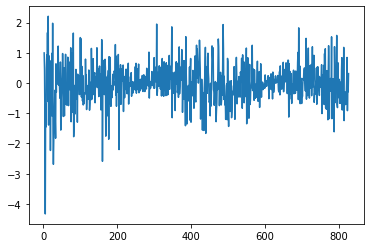

In [ ]:
residuals = model_fit.resid
residuals.plot()
residuals.describe()
#no trend or seasonality in the data
#no values missing information

In [ ]:
#forcasting future value
output = model_fit.forecast()
output


(array([13.74]), array([0.64]), array([[12.5 , 14.99]]))

Walkforward ARIMA

In [ ]:
train_size = int(series_2.shape[0]*0.7)
train, test = series_2.avg_energy[0:train_size], series_2.avg_energy[train_size:]

SARIMA Model (seasonal ARIMA)

In [ ]:
#arima can only handle trend after differentiational 
#this version allows inclusion of trend and seasonality


In [ ]:
data = train
predict = []
for t in test:
  model = ARIMA(data, order= (7,2,3))
  model_fit = model.fit()
  y = model_fit.forecast()
  print(y[0][0])
  predict.append(y[0][0])
  data = np.append(data, t)
  data = pd.Series(data)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


10.58441446121561
10.8640390108946
11.379570447606099
11.08226015073786
10.36427584260074
10.465417267454075


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


10.590758130764495
11.024476173723423


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


10.60598272300925


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10.455936043151459
10.073654845181691
10.737154444341819


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


10.774062012013854
10.486740480130763
10.04262837244496
10.098012114572343
10.23238821776867


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10.26860878061547
10.054349634029245
9.879979272993808
9.8884952641829
9.784344501368645
9.799644413163024
10.028152677788047
9.997632831201544
9.901348094507977
9.984775308724194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


9.797314730201247
9.809712444086369
9.99581998258898
10.04370556724677


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10.160843215678092
10.220520486983242
9.711042623826515
9.911540698372205
9.710703300008191
9.98273977792279
9.936775713837825


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9.854972857085826
9.938896733351589


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9.85806699528038
9.692656153791075
9.882468523635197
9.372618112049281
9.80370445924023
10.027123208115116


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9.617730483995896
9.517617262400313
9.591877454780088
9.548300585390626


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9.823028960462926
10.000852083557582
9.822949333611158
9.797730945828198
9.791453969337626


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9.85584570989907
9.983851955271817
10.185423783922223


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10.199065910301115
9.965160299888746
9.637605965009108


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9.71887616162666
10.17041089441707
9.869852106009036


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10.347566736289425
10.016179673488798
9.894988360030137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10.106057529418909
10.018282416576529
9.79901033040817
10.075134886666879
10.04672267482143
10.659599336900992
10.321114024589251
10.126027365450406
10.19853172763413
10.32248290547813
10.734689217700163
10.891969785464717
11.144545352136978


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.498866287006274
11.52234606223651


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.758043744004455
11.35894280594355
11.5552678961637
12.340480112811619


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12.92013878379074


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.69532083977033
12.231551109049606


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.502611596098808


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12.064003454378149
12.006153068955259
12.132761849096573
11.989979958098717


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.915500896003785


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.178996463835565
11.264738313834494
11.161026738601512
11.305865105905468
11.843402593935997
11.976234655901411
11.335108136303262
11.640322422927662
11.711781274872587


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.677879364127692
11.497718555560661


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.977591485265986
11.966474269024932
11.841696467767665
11.59833789793456
11.623284904146868
12.048929539207894
12.979723428099705


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12.461150218340045


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13.738542223170167
13.025891459252282
12.633380894947384
13.353145375265035


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12.773941030240021
12.391206618612795


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13.1560603539074


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12.981329326000191
12.310505038144113
12.421486851956784


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.934619156586974


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


ValueError: ignored

In [ ]:
#for chunk below when done loading
 
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test.valuesm, predict)
mse

AttributeError: ignored

SARIMAX model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.seasonal import seasonal_decompose
series_2.index = series_2['day']



In [ ]:
model = SARIMAX(series_2['avg_energy'], order=(7,2,3), seasonal_order=(1,1,1,12))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


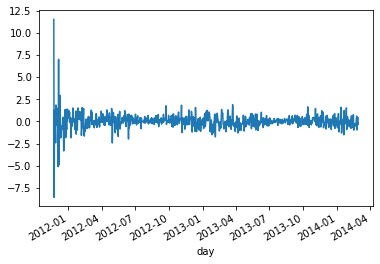

In [ ]:
residuals = model_fit.resid
residuals.plot()

In [ ]:
output = model_fit.forecast()
output

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


828    13.005346
dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


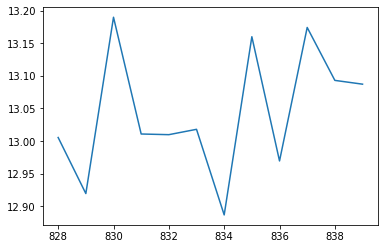

In [ ]:
future_forcast = model_fit.forecast(12)
future_forcast.plot()
#forcast for the next 12 days


In [ ]:
yhat = model_fit.predict()

In [ ]:
yhat.head()

day
2011-11-23     0.000000
2011-11-24    19.252499
2011-11-25     9.758304
2011-11-26    11.469528
2011-11-27    13.352138
dtype: float64

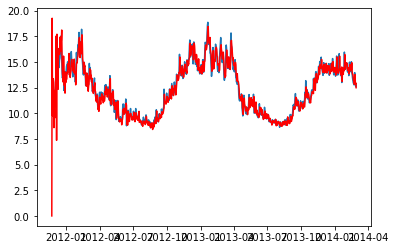

In [ ]:
pyplot.plot(series_2['avg_energy'])
pyplot.plot(yhat, color = 'red')

Simple Linear

In [ ]:
import statsmodels.api as sn


In [ ]:
#Feature engineering
series_2['days_from_start'] = (series_2.index - series_2.index[0]).days; series_2

,day,energy_sum,LCLid,avg_energy,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,Bank holidays,holiday_ind,days_from_start
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-23,2011-11-23,46.206000,4,11.551500,10.36,2011-11-23,229,fog,6.29,2011-11-23,0.36,2.04,1027.12,2011-11-23,10.36,rain,8.06,0.93,2011-11-23,6.56,10.36,1.0,2011-11-23,2011-11-23,8.24,3.81,10.36,2011-11-23,2011-11-23 14:00:00,2011-11-23,Foggy in the morning.,2011-11-23,2.18,2011-11-23,2011-11-23,0.94,2011-11-23,1,0
2011-11-24,2011-11-24,106.549000,10,10.654900,12.93,2011-11-24,204,partly-cloudy-night,8.56,2011-11-24,0.41,4.04,1027.22,2011-11-24,12.93,rain,10.64,0.89,2011-11-24,7.30,12.93,1.0,2011-11-24,2011-11-24,9.71,8.56,12.93,2011-11-24,2011-11-24 12:00:00,2011-11-24,Partly cloudy throughout the day.,2011-11-24,7.01,2011-11-24,2011-11-24,0.97,NaN,0,1
2011-11-25,2011-11-25,154.871000,14,11.062214,13.03,2011-11-25,243,partly-cloudy-day,7.24,2011-11-25,0.48,5.02,1024.47,2011-11-25,12.27,rain,12.38,0.79,2011-11-25,4.69,13.03,1.0,2011-11-25,2011-11-25,7.01,7.46,12.27,2011-11-25,2011-11-25 12:00:00,2011-11-25,Partly cloudy throughout the day.,2011-11-26,4.84,2011-11-25,2011-11-26,0.01,NaN,0,2
2011-11-26,2011-11-26,207.522000,17,12.207176,12.96,2011-11-26,237,wind,6.96,2011-11-26,0.44,5.75,1025.80,2011-11-26,12.96,rain,13.07,0.81,2011-11-26,11.59,12.96,1.0,2011-11-26,2011-11-26,11.59,7.01,12.96,2011-11-26,2011-11-26 14:00:00,2011-11-26,Mostly cloudy throughout the day and breezy ov...,2011-11-26,4.69,2011-11-26,2011-11-26,0.05,2011-11-26,1,3
2011-11-27,2011-11-27,214.387000,17,12.611000,13.54,2011-11-27,256,wind,5.76,2011-11-27,0.42,5.48,1021.11,2011-11-27,13.54,rain,13.08,0.72,2011-11-27,1.31,13.54,1.0,2011-11-27,2011-11-27,1.31,4.47,13.54,2011-11-27,2011-11-27 10:00:00,2011-11-27,Breezy in the morning and partly cloudy until ...,2011-11-28,2.94,2011-11-27,2011-11-28,0.08,2011-11-27,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-23,2014-02-23,22581.997996,1618,13.956735,11.94,2014-02-23,200,wind,6.17,2014-02-23,0.66,7.10,1010.37,2014-02-23,11.94,rain,12.33,0.76,2014-02-23,5.52,11.94,1.0,2014-02-23,2014-02-23,7.99,8.67,11.94,2014-02-23,2014-02-23 16:00:00,2014-02-23,Mostly cloudy until evening and breezy until a...,2014-02-24,5.53,2014-02-23,2014-02-24,0.78,2014-02-23,1,823
2014-02-24,2014-02-24,20691.832000,1617,12.796433,14.23,2014-02-24,183,wind,6.03,2014-02-24,0.50,5.02,1005.19,2014-02-24,14.23,rain,13.00,0.74,2014-02-24,4.78,14.23,1.0,2014-02-24,2014-02-24,8.25,7.99,14.23,2014-02-24,2014-02-24 13:00:00,2014-02-24,Mostly cloudy until evening and breezy overnight.,2014-02-25,5.52,2014-02-24,2014-02-25,0.82,NaN,0,824
2014-02-25,2014-02-25,20628.431997,1618,12.749340,11.43,2014-02-25,202,partly-cloudy-day,5.06,2014-02-25,0.62,5.69,1000.65,2014-02-25,10.31,rain,12.09,0.78,2014-02-25,1.67,11.43,1.0,2014-02-25,2014-02-25,4.17,6.79,10.31,2014-02-25,2014-02-25 14:00:00,2014-02-25,Mostly cloudy throughout the day.,2014-02-26,3.89,2014-02-25,2014-02-26,0.86,NaN,0,825


In [ ]:
#X_days = series_2['days_from_start'].values.reshape(-1, 1)
#X_Weather_variabe = series_2['cloudCover'] #could use any weather variable available
#y = series_2['avg_energy'].values

In [ ]:
X = sn.add_constant(series_2['days_from_start']) #independant variable
X_Weather_variabe = sn.add_constant(series_2['cloudCover']) #could use any variable
lm = sm.OLS(series_2['avg_energy'], X).fit() #dependant variable
lm.summary() #summary of the model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_energy   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.004451
Date:                Wed, 18 Aug 2021   Prob (F-statistic):              0.947
Time:                        17:00:15   Log-Likelihood:                -1893.8
No. Observations:                 828   AIC:                             3792.
Df Residuals:                     826   BIC:                             3801.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.3881      0.165     74.912      0.000      12.064      12.713
days_from_start -2.316e-05      0.000     -0.067      0.947      -0.001       0.001
==============================================================================
Omnibus:                      313.360   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.900
Skew:                           0.166   Prob(JB):                     1.08e-10
Kurtosis:                       1.895   Cond. No.                         950.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from sklearn.linear_model import LinearRegression
y = series_2['avg_energy']
X = series_2[['days_from_start']]
X_Weather_variabe = series_2[['temperatureHigh']]

lm2 = LinearRegression()
lm2.fit(X, y)
print(lm2.intercept_, lm2.coef_)
#intercept = 12.388, coeff of X = -2.32e-05

12.388094888491917 [-2.32e-05]


In [ ]:
#predict values of y
lm2.predict(X)

In [ ]:
lm2 = LinearRegression()
lm2.fit(X_Weather_variabe, y)
print(lm2.intercept_, lm2.coef_)

16.90280680693613 [-0.33]


In [ ]:
lm2.predict(X_Weather_variabe)